# 0.0 IMPORTS 

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import xgboost as xgb
import random
import warnings
import pickle
import sklearn

from tabulate import tabulate
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec 
from scipy                 import stats
from boruta                import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [2]:
####   CROSS VALIDATION

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {} '.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # Validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteraction
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2).astype( str),
                          'MAPE CV': np.round( np.mean( mape_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2).astype( str),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype( str) }, index=[0])
    

def mean_percentage_error( y, yhat ):
    return np.mean( ( y -yhat ) / y ) 
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y -yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error(y, yhat )
    mape = mean_absolute_percentage_error(y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )    

def cramer_v( x, y ):
    #cm = pd.crosstab( x, y ).as_matrix()
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 )))  

# Função para ampliar area de edição do jupyter notebook
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] =24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()    

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [4]:
# leitura dos dados fornecidos
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# merge de datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
# teste de leitura simples
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
386672,832,4,2014-07-24,5241,484,1,0,0,0,d,a,5070.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [6]:
# fazer uma cópia do dataset quando muda de seção, somente para manter os dados , caso seja necessário recomeçar
df1 = df_raw.copy()

In [7]:
# visualizando os nomes das colunas do dataset
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [8]:
# renomenado as colunas para facilitar analise dos dados
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x)
cols_new = list( map(snakecase, cols_old))

#rename
df1.columns = cols_new
#visualizando as colunas renomeadas
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [9]:
# leitura de colunas/linhas do dataset para dimensionar os dados
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [10]:
# leitura do tipos de dados de cada coluna
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Ckeck NA

In [11]:
# Verificando colunas com registros vazios
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
#competition_distance --> 2642 registros vazios
# Verificando qual a maior distancia de um concorrente  -> 75860.0
# SOLUÇÃO para popular registros vazios-> Vou aplicar uma distancia maxima = 200000.0 para os registros NAN desta coluna
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

#===============================================================================================================
#competition_open_since_month --> 323348 registros vazios
# mes que o concorrente mais proximo foi aberto. Pq este campo esta vazio? a loja ja estava aberta quando instalou a nossa loja ou ninguem resgistrou esta informação
# SOLUÇÃO para popular registros vazios-> APLICAR A DATA (mes) DE VENDA NESTE CAMPO, PARA DEPOIS TESTAR USANDO CRISP E AVALIAR O ALGORITMO
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#===============================================================================================================
#competition_open_since_year --> 323348 registros vazios
# IDEM solução do item anterior
# SOLUÇÃO para popular registros vazios-> APLICAR A DATA (ano) DE VENDA NESTE CAMPO, PARA DEPOIS TESTAR USANDO CRISP E AVALIAR O ALGORITMO
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#===============================================================================================================
#promo2_since_week --> 508031 registros vazios
# SOLUÇÃO para popular registros vazios-> APLICAR A DATA (semana) DE VENDA NESTE CAMPO, PARA DEPOIS TESTAR USANDO CRISP E AVALIAR O ALGORITMO
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#===============================================================================================================
#promo2_since_year --> 508031 registros vazios
# SOLUÇÃO para popular registros vazios-> APLICAR A DATA (ano) DE VENDA NESTE CAMPO, PARA DEPOIS TESTAR USANDO CRISP E AVALIAR O ALGORITMO
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#===============================================================================================================
#promo_interval --> 508031 registros vazios
#criando um mapa de mês
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Colocando 0 nos registros que possui a coluna promo_interval = 0
df1['promo_interval'].fillna( 0, inplace=True )

# Criei uma coluna month_map onde será gravado o mes da coluna 'date' do registro, já convertido de acordo com a biblioteca criada
df1['month_map'] = df1['date'].dt.month.map( month_map )

# Criei uma nova coluna que vai registrar 1 para quem tem promoção no mes de venda e 0 data de venda fora da promoçao
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [13]:
# releitura para conferir se ainda temos registros vazios
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change types

In [14]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [15]:
# releitura dos tipos de dados para conferencia
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [16]:
# Criando dataframes de acordo com o typo da coluna
num_attributes = df1.select_dtypes( include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [17]:
# Dividindo o datafame em dados numéricos e categóricos
# Realizar calculos basicos para cada coluna, para ter uma noção dos dados

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
#Rename columns
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

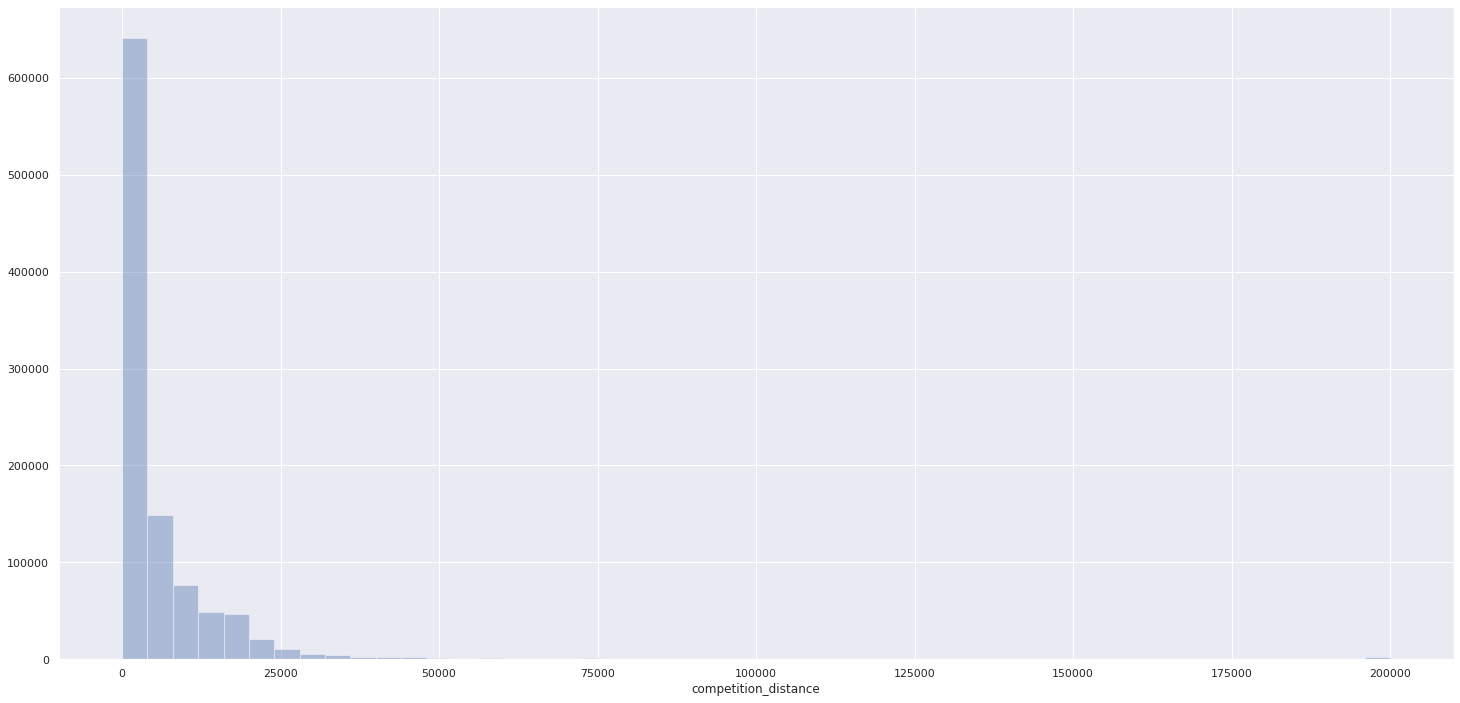

In [18]:
sns.distplot( df1['competition_distance'], kde=False )

## 1.7.2 Caterigal Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

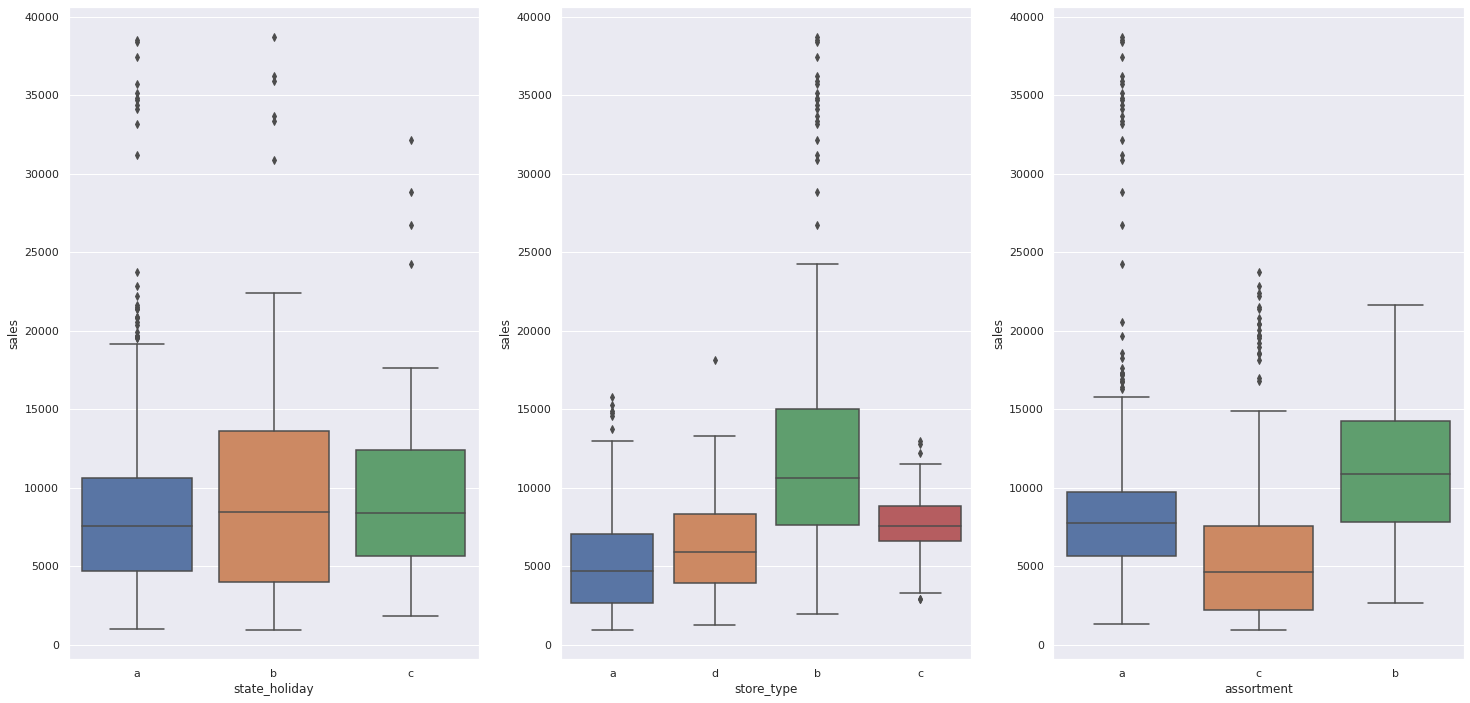

In [20]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [21]:
# fazer uma cópia do dataset ao ir para um próximo passo ou seção, somente para manter os dados , caso seja necessário recomeçar
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

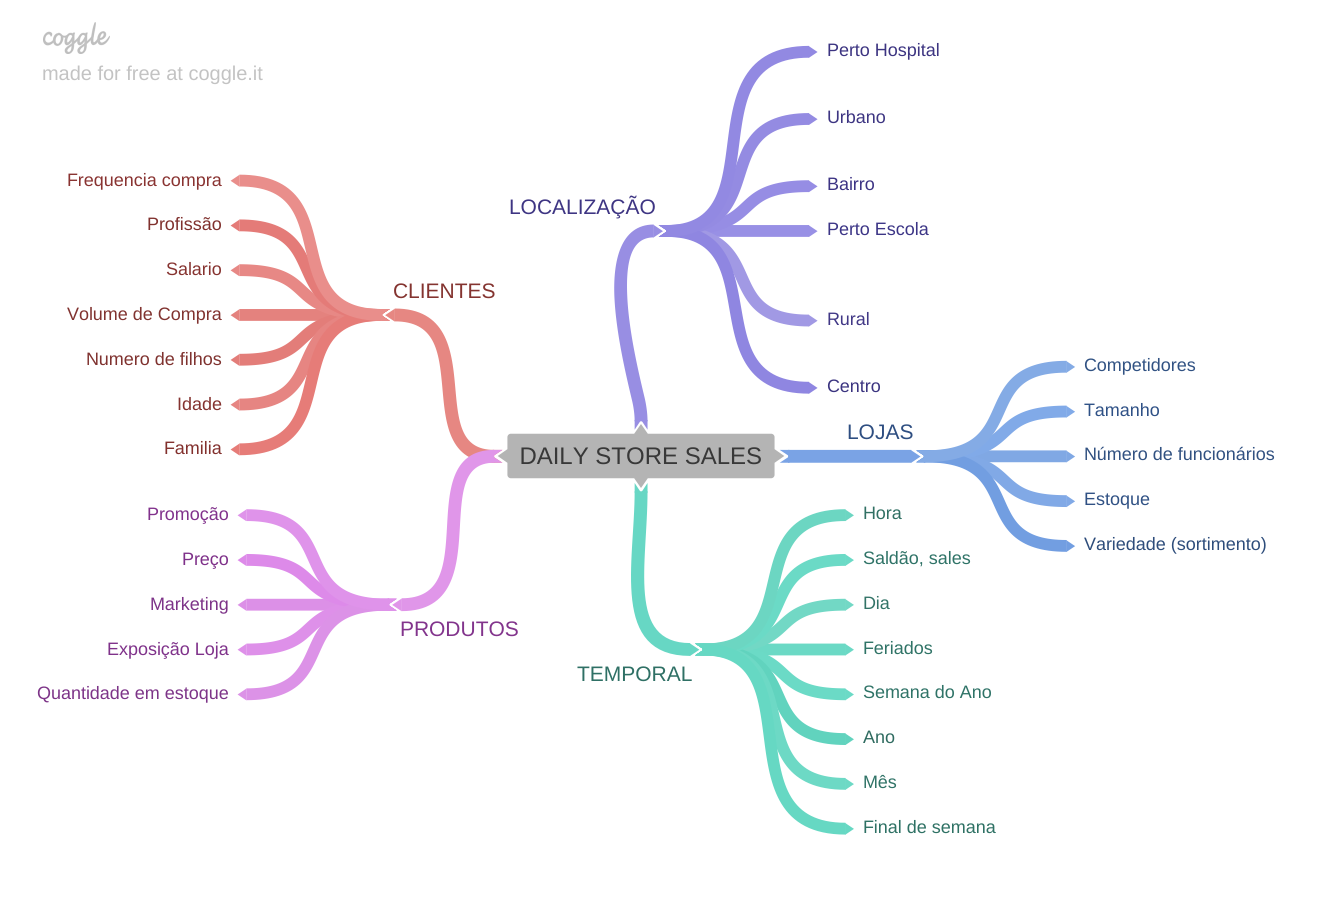

In [22]:
# Feito Feature Engineering para criar listas de hipóteses e validar dados
Image('../img/DAILY_STORE_SALES.png')

## 2.1. Criação das Hipóteses

### 2.1.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (desconto maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao lojgo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Lista final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao lojgo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Feature Engineering

In [23]:
# Criando novas features utilizando os dados do dataset
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [24]:
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30 ).apply(lambda x: x.days).astype(int)

In [25]:
# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7 ).apply(lambda x: x.days).astype(int)

In [26]:
# ASSORTMENT
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [27]:
# State holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 

In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [29]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [30]:
# criando novo dataset com lojas abertas e com vendas
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [31]:
# removendo colunas desnecessárias para analise de dados e deixar o processamento mais rapido
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS (EDA)

In [33]:
#Etapa para medir impacto das variáveis, quantificar seu impacto, validar hipóteses de negócios e gerar INSIGHTS
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales'>

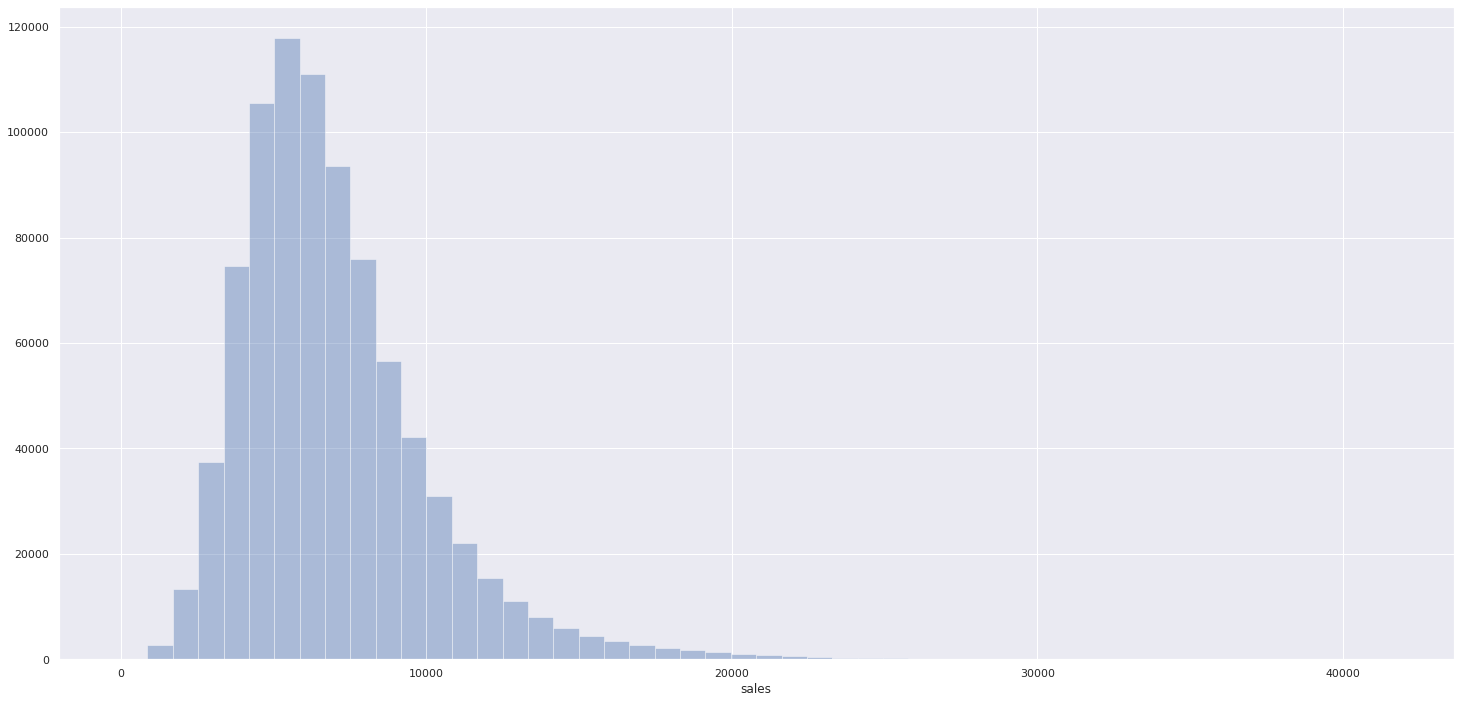

In [34]:
#plt.figure( figsize=(220,112))
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Numerical Variable

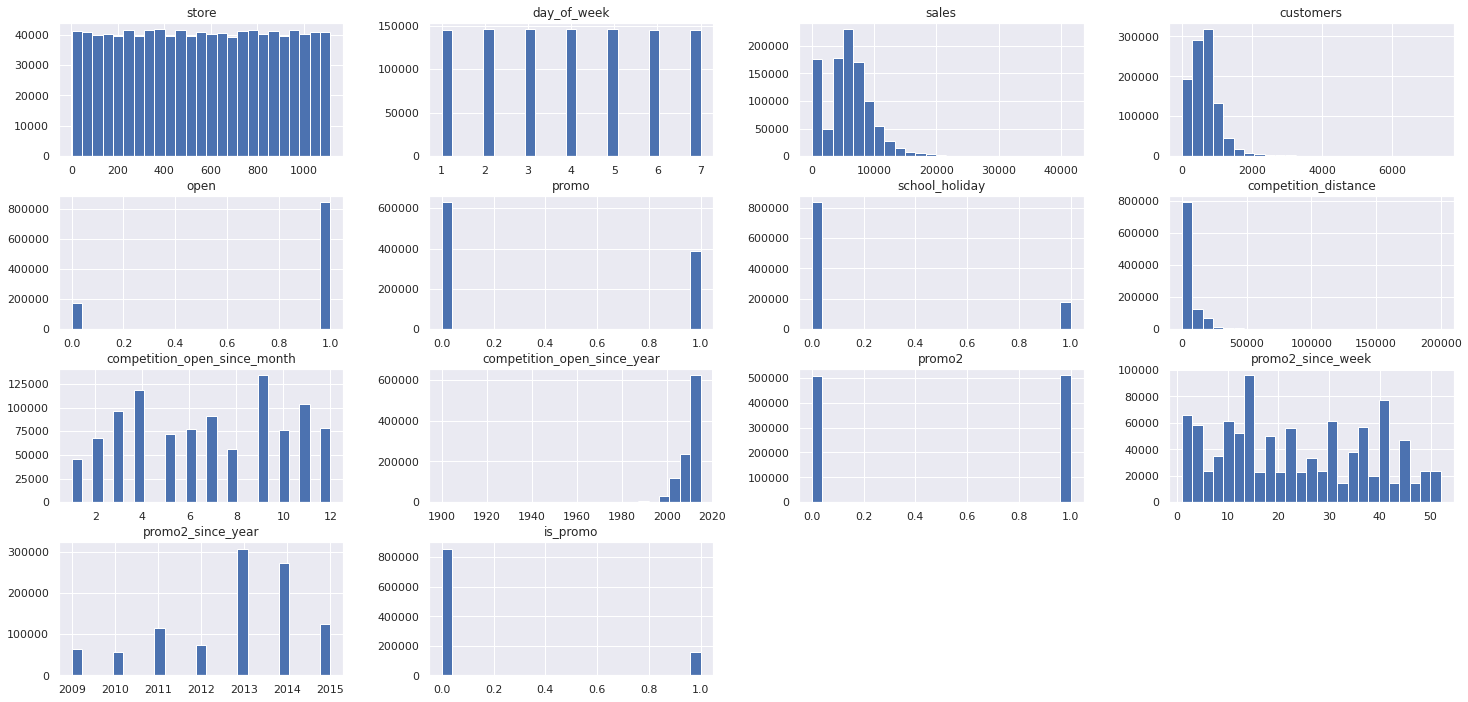

In [35]:
#plt.figure( figsize=(220,112))
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [36]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [37]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [38]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

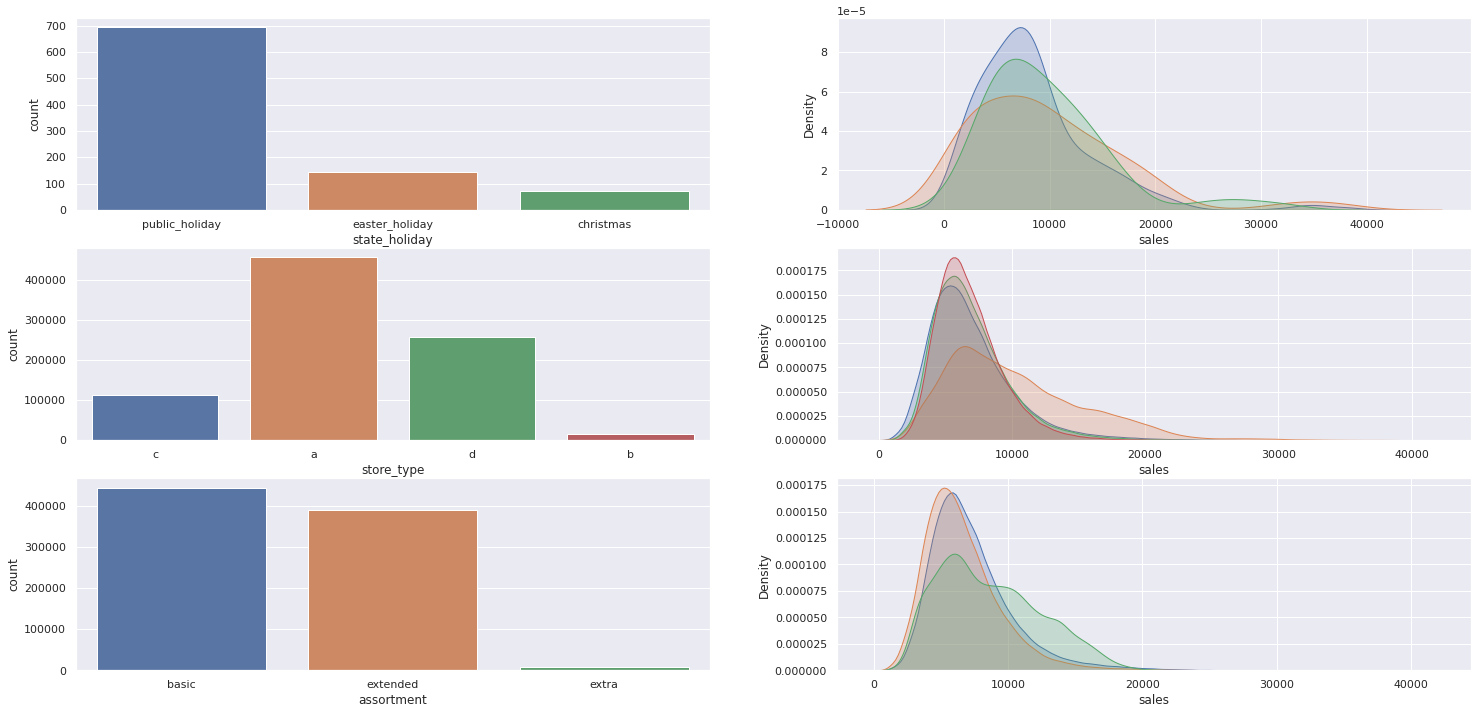

In [39]:
# state_holiday
#criando um grafico com todos os feriados

plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'])

#Criando um grafico com as colunas sobrepostas -> shade=True
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#==========================================================================================================

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

#==========================================================================================================

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


## 4.2. Analise Bivariada

## H1.  Lojas com maior sortimentos deveriam vender mais.
***FALSA***  Lojas com MAIOR SORTIMENTO vendem MENOS

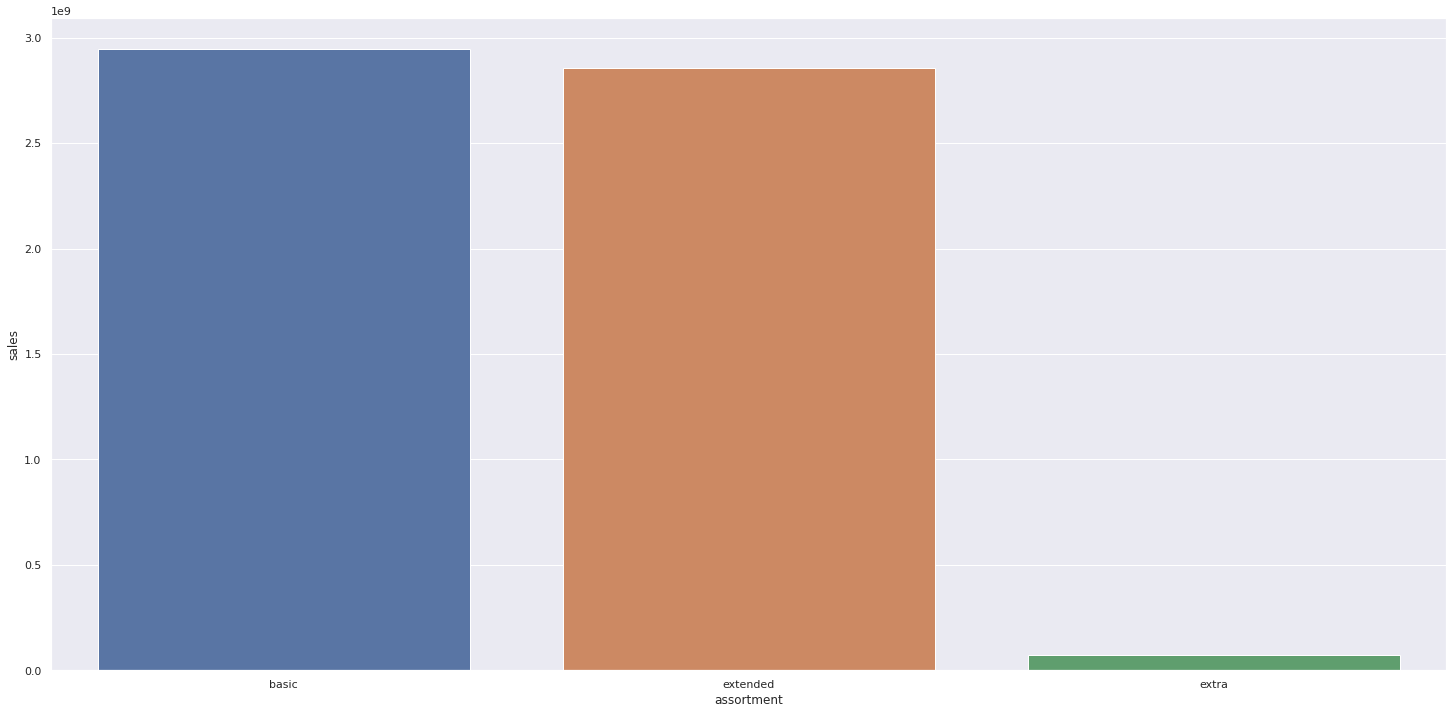

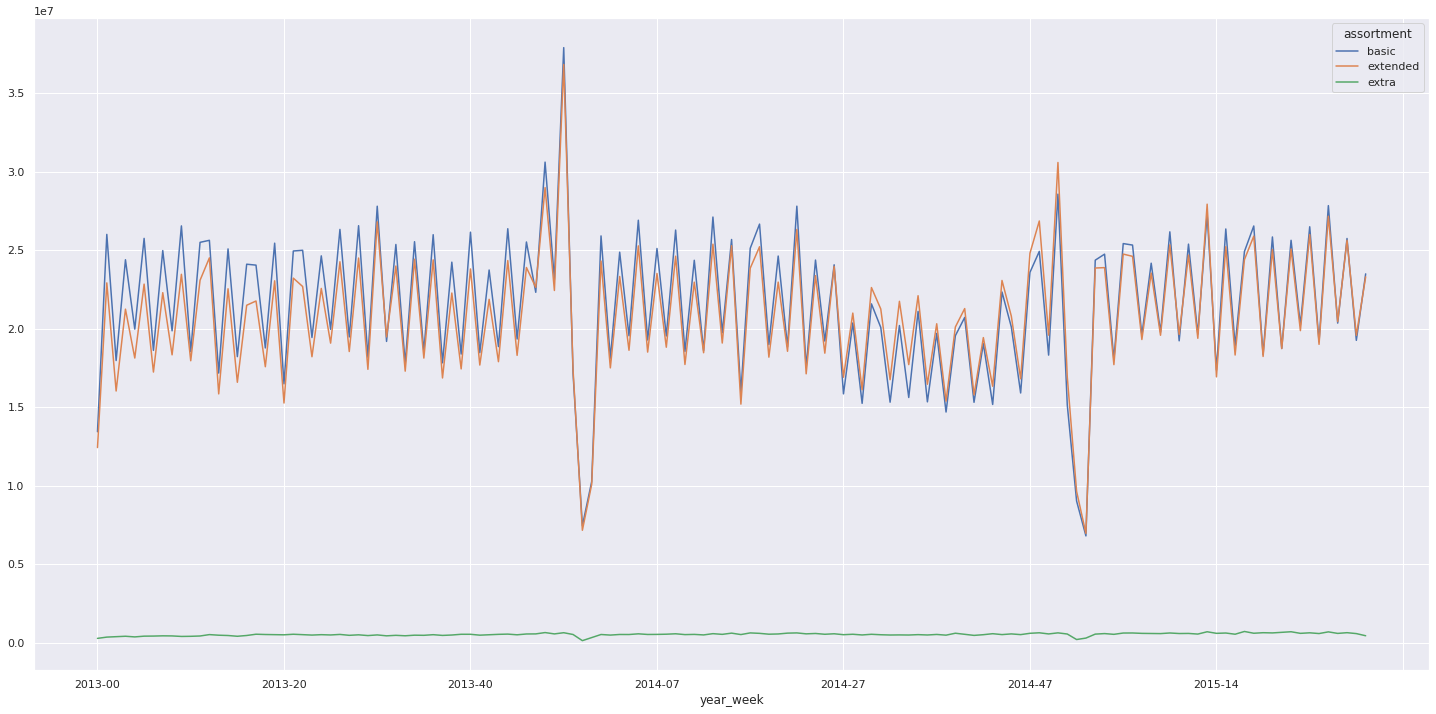

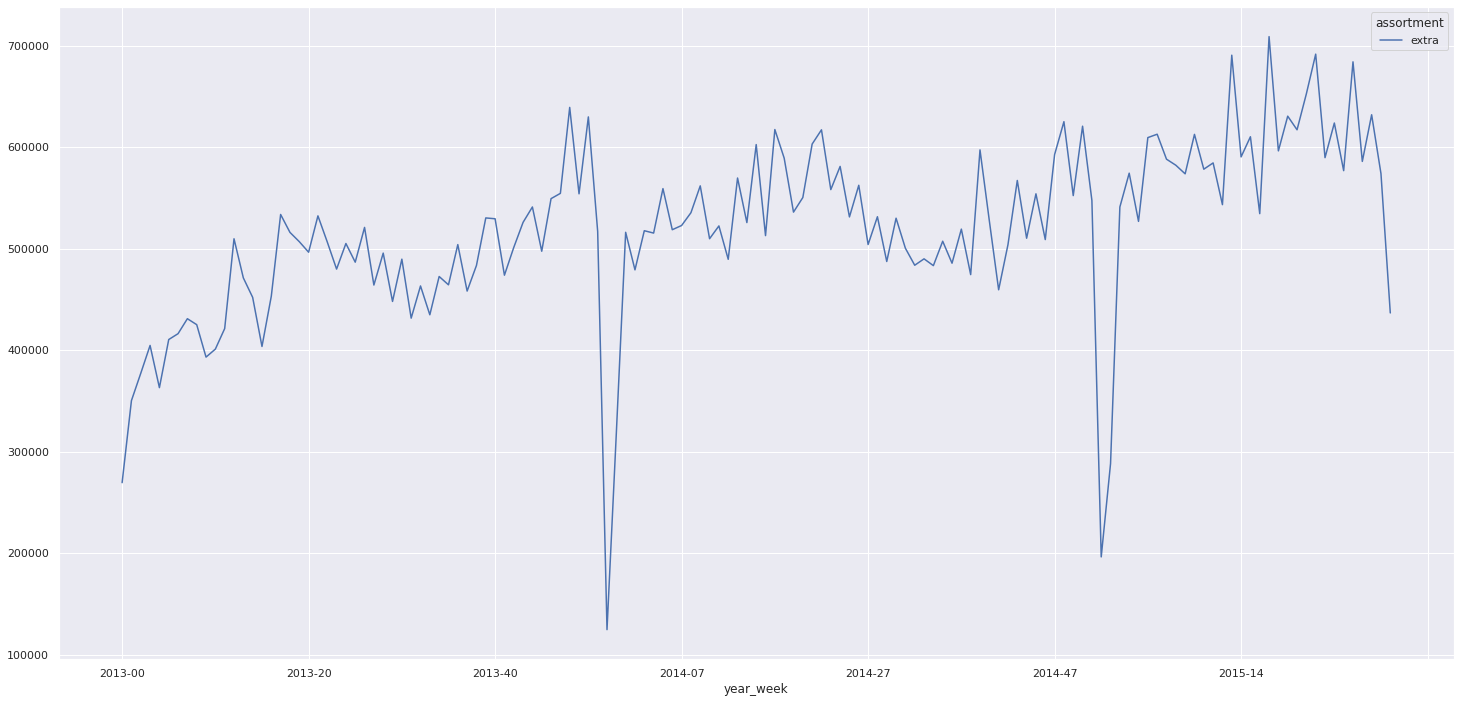

In [40]:
#sortimento + vendas --> agrupa por sortimento
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

#semana do ano + sortimento + vendas  --> agrupa por semana do ano + sortimento
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot();

# verificando somente o sortimento extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot();

## **H2.** Lojas com competidores mais próximos deveriam vender menos.
***Falsa*** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

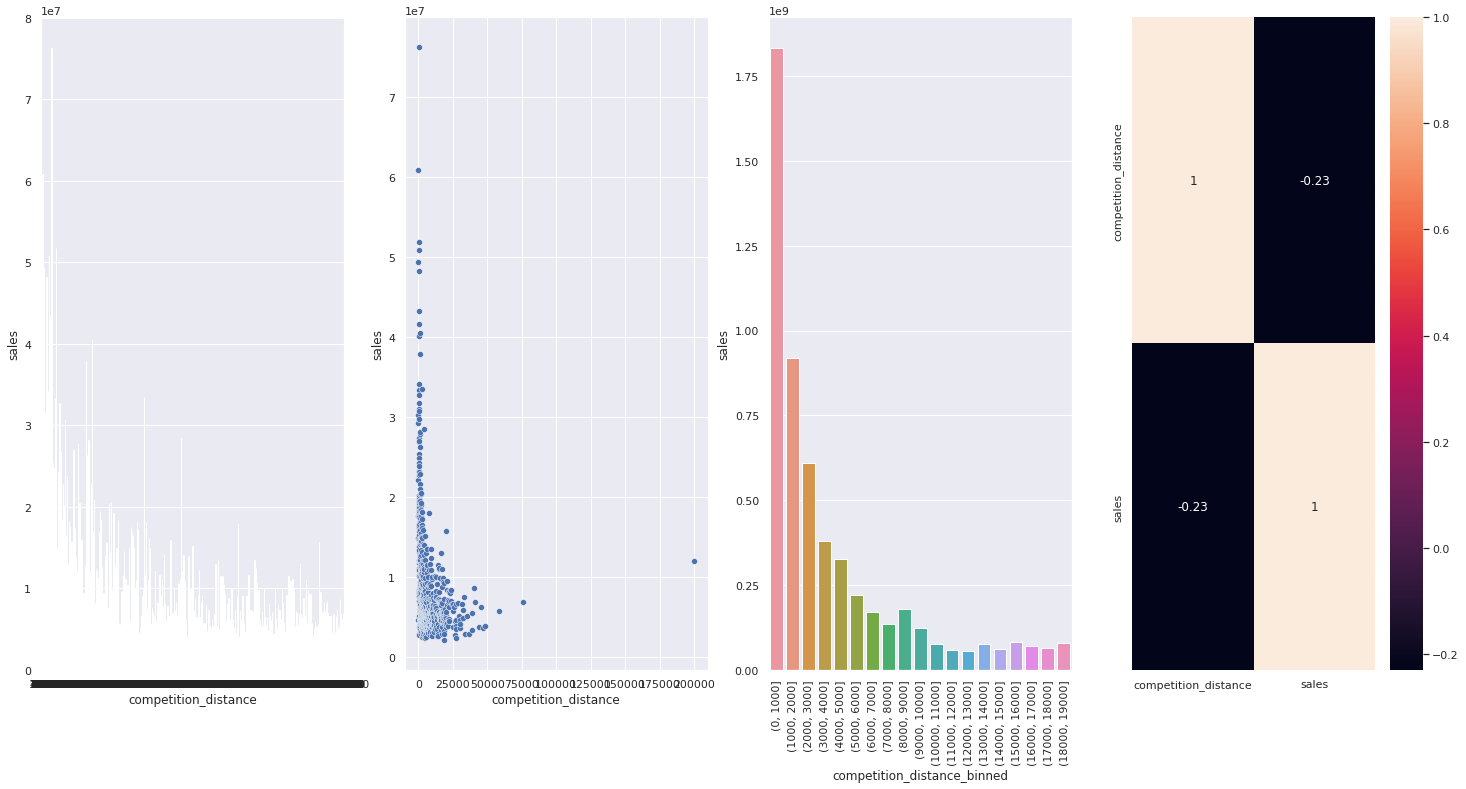

In [41]:
#sortimento + vendas --> agrupa por sortimento

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,4,1)
sns.barplot(x='competition_distance', y='sales', data=aux1);


aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,4,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);


plt.subplot(1,4,3)
#criando uma lista para agrupar as distancias
# vai de 0 a 20000 e com 1000(grupos) agrupamentos
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);


plt.subplot(1,4,4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H3.** Lojas com competidores a mais tempo deveriam vender mais.
***Falsa*** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS


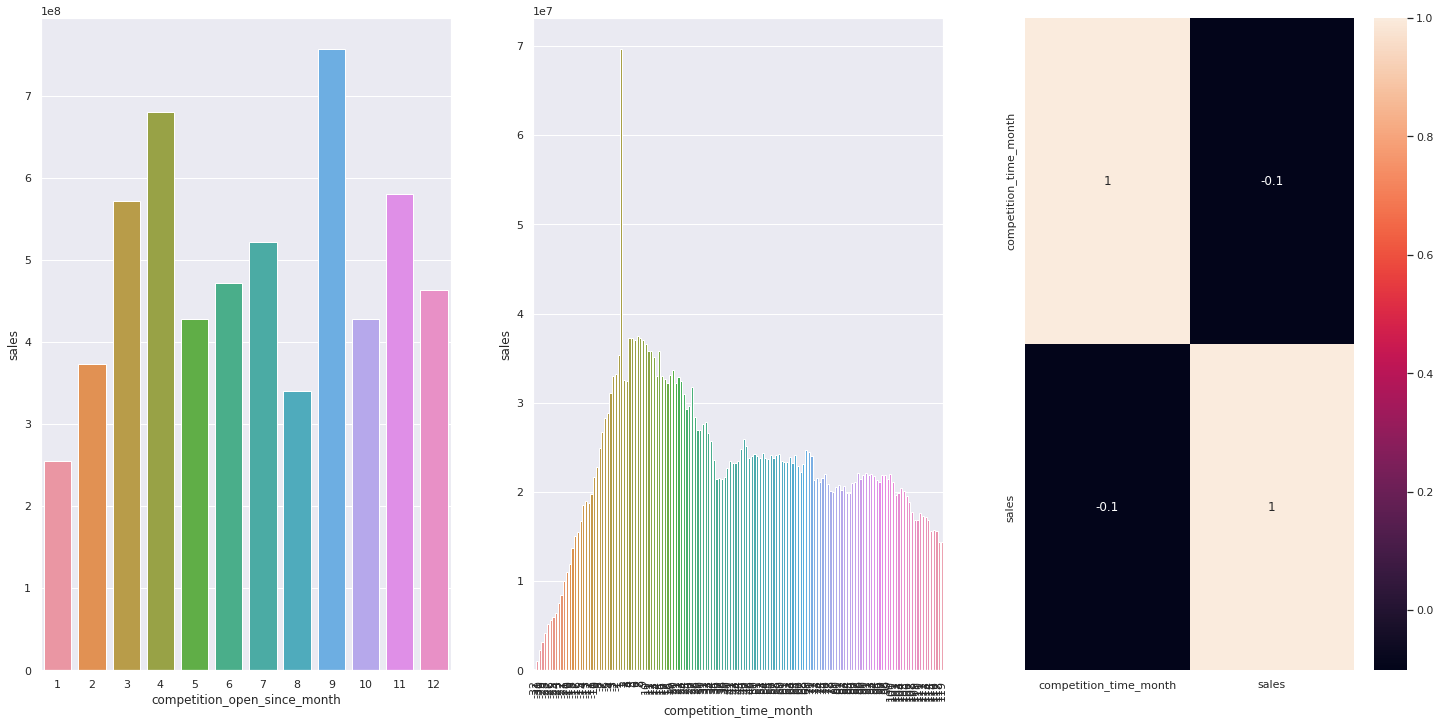

In [42]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').sum().reset_index()
sns.barplot( x='competition_open_since_month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
aux2 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux3 = aux2[( aux2['competition_time_month'] < 120) & (aux2['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux3);
plt.xticks( rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap( aux2.corr(method='pearson'), annot=True);

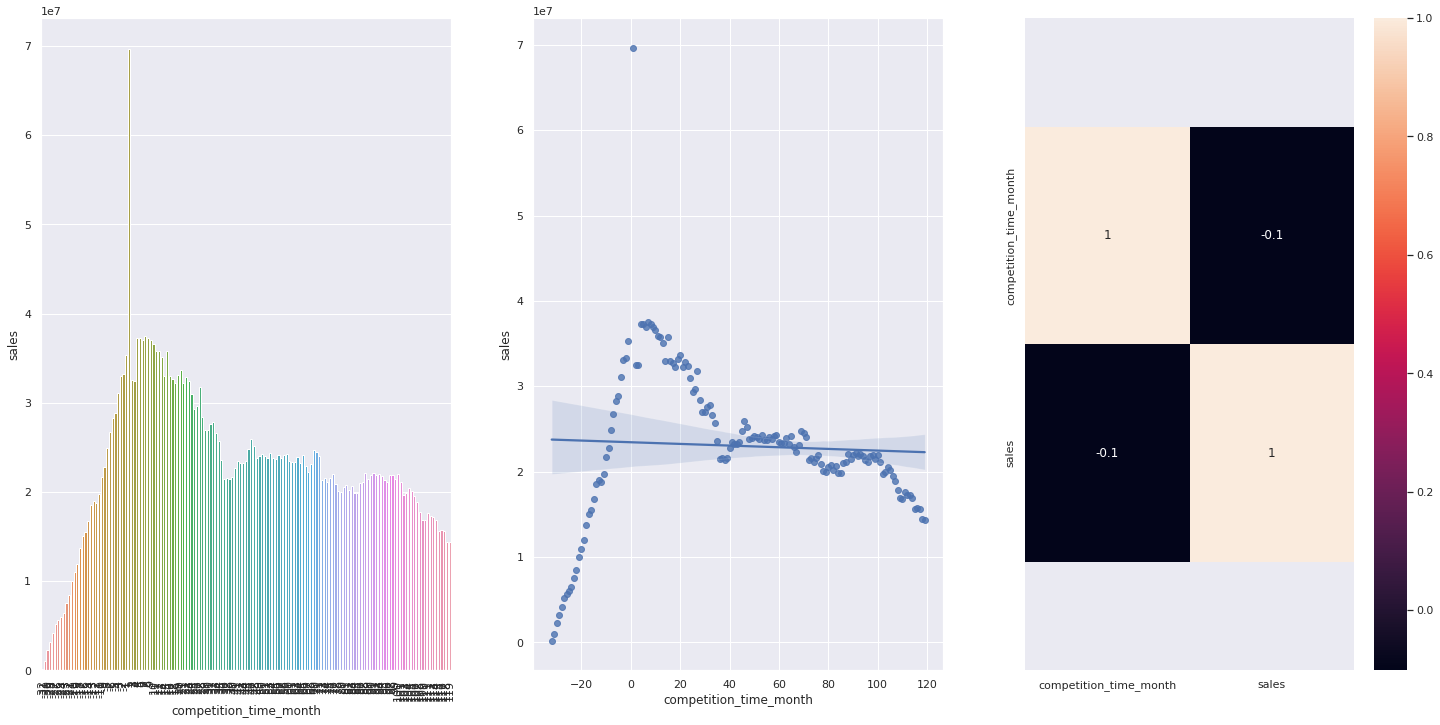

In [43]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

## **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
***Falsa***  Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção


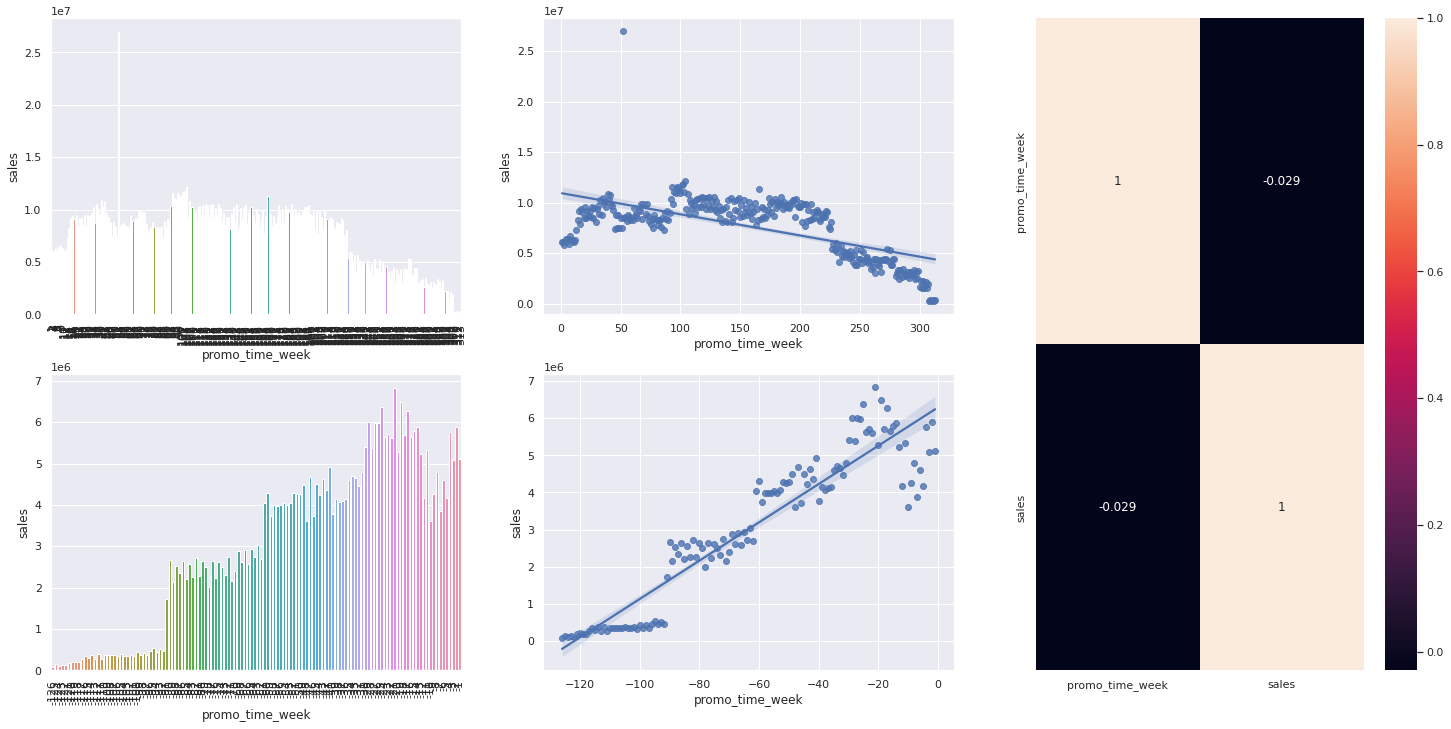

In [44]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ]  # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H5.** Lojas com mais dias de promoção deveriam vender mais.

***Validar*** no proximo ciclo crisp

## **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
***Falsa***  Lojas com ais promoções consecutivas vendem menos

In [45]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


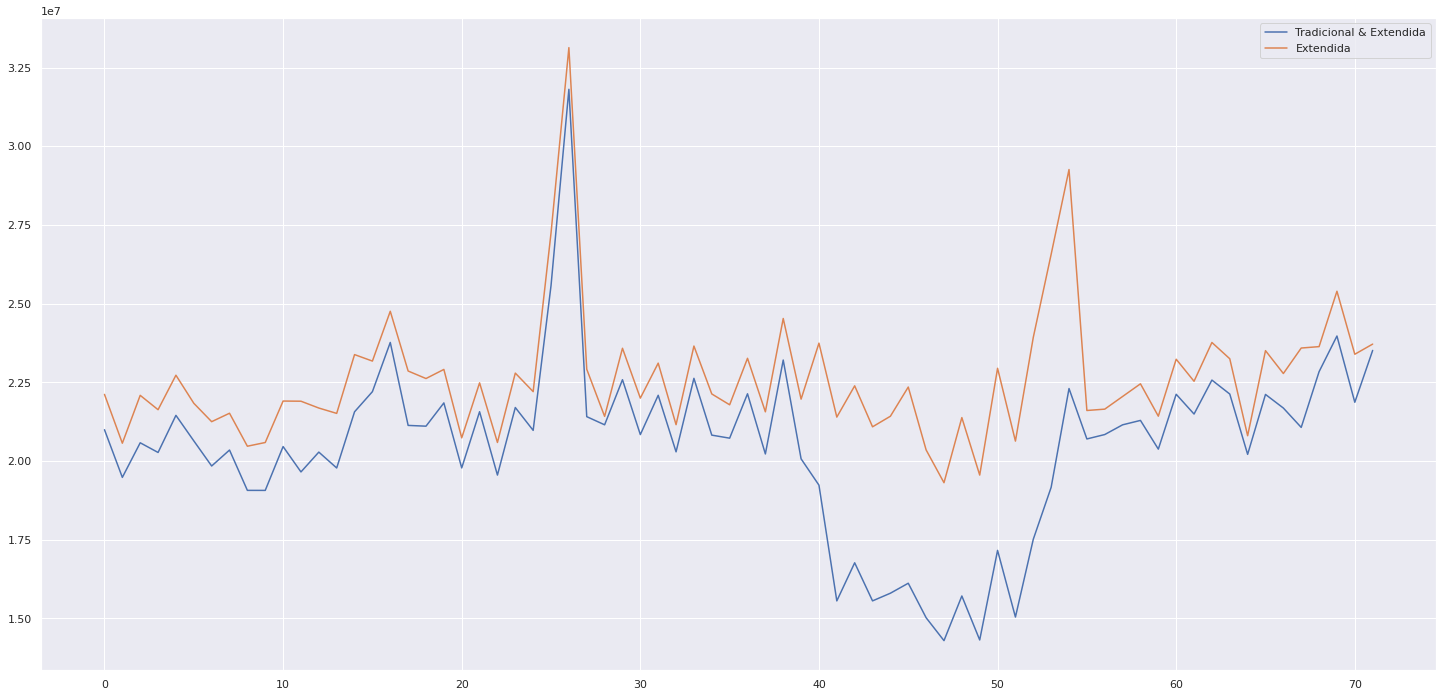

In [46]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

## **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
***Falsa*** Lojas abertas durante o feriado do Natal vendem menos


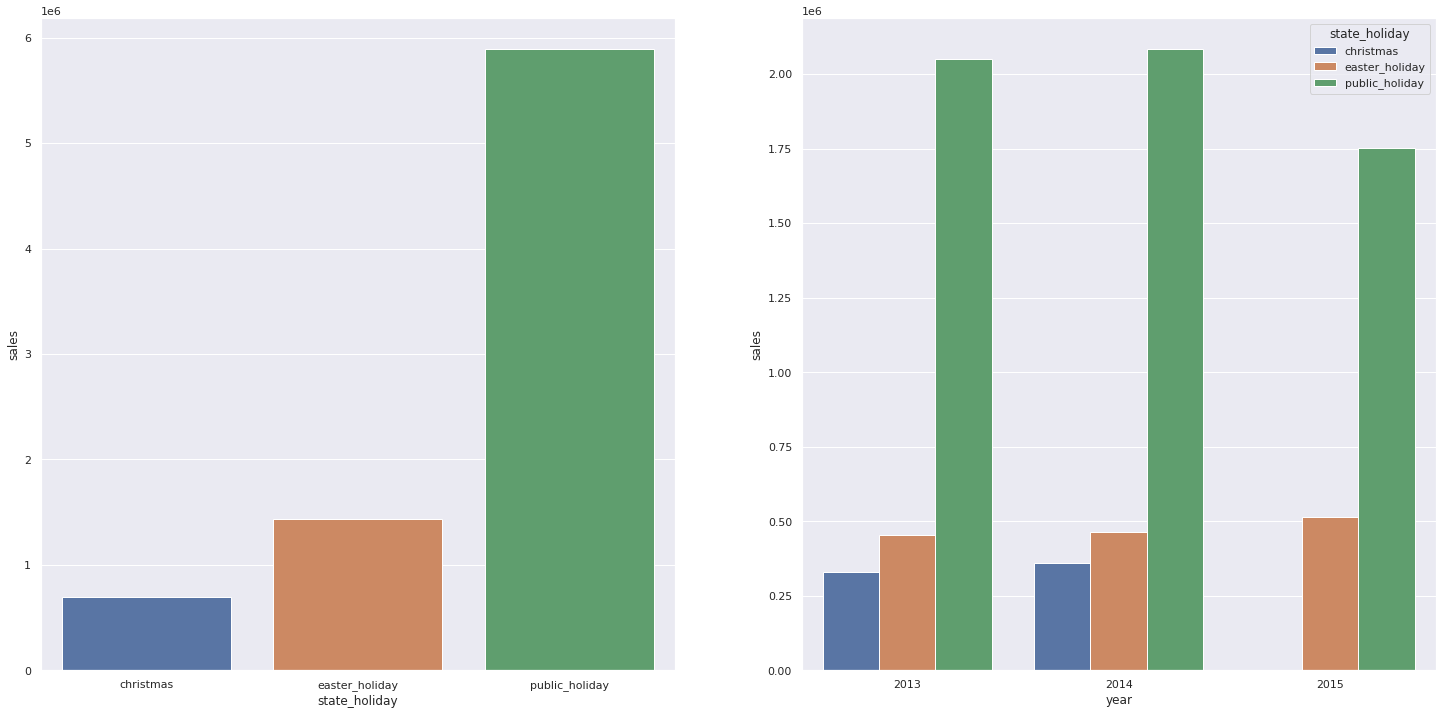

In [47]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

## **H8.** Lojas deveriam vender mais ao lojgo dos anos.
***Falsa***  Lojas vendem menos ao longo dos anos

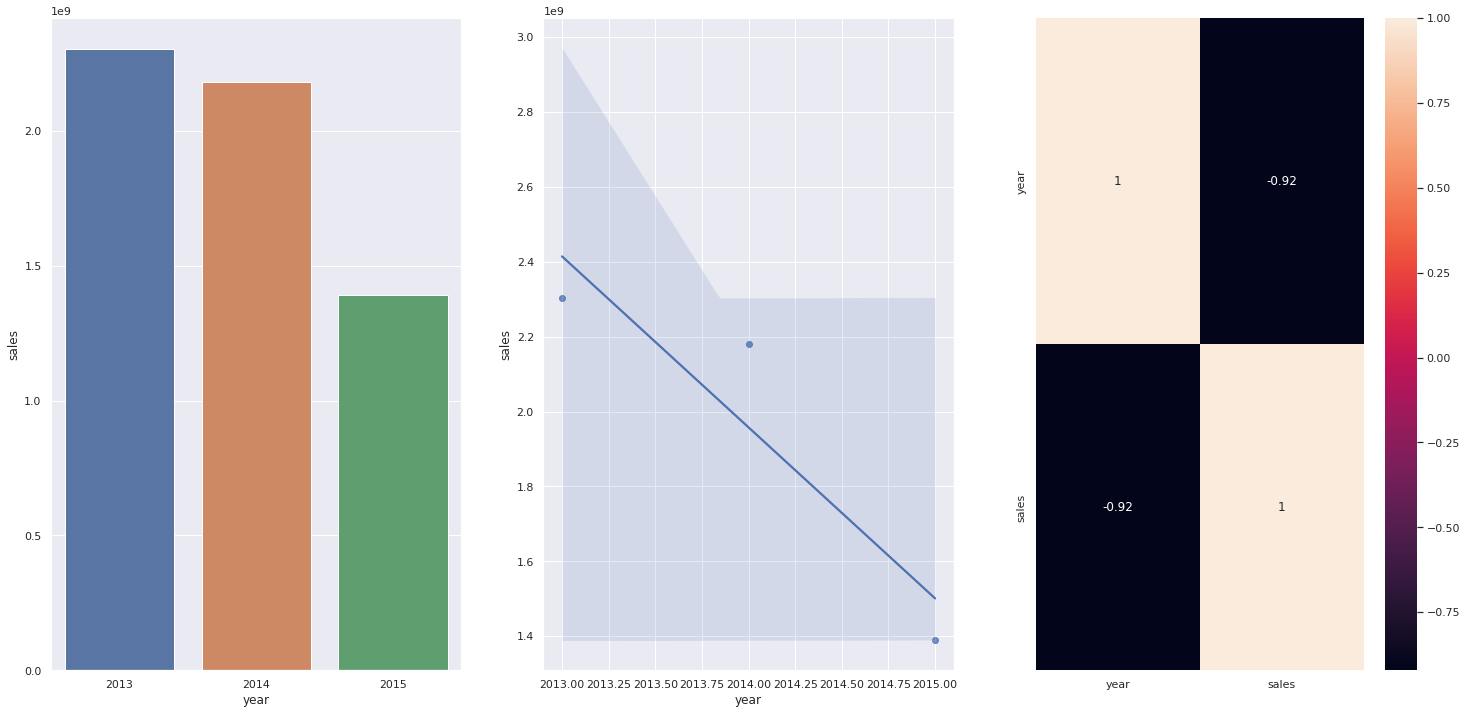

In [48]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H9.** Lojas deveriam vender mais no segundo semestre do ano.
***Falsa***  Lojasvendem menos no segundo semestre do ano



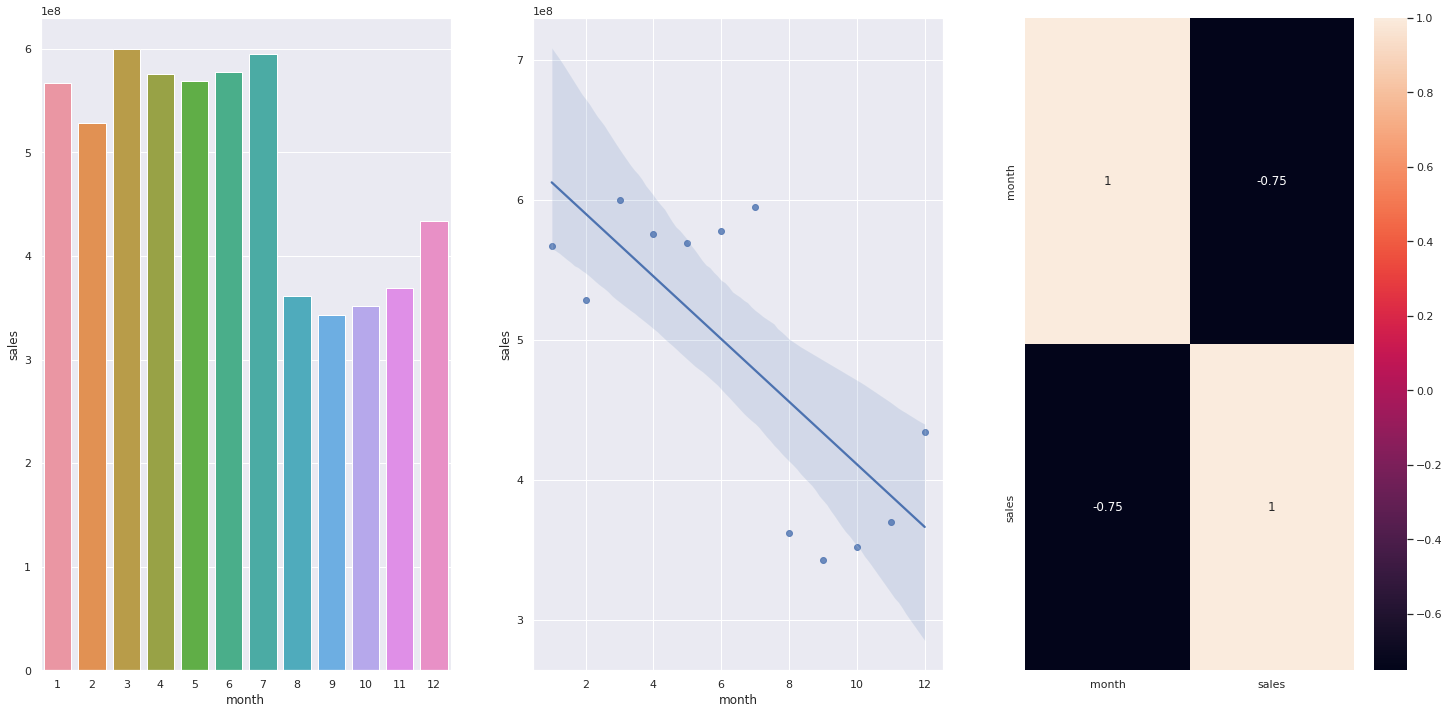

In [49]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
***Verdadeira*** Lojas vendem mais depois do dia 10 de cada mes

In [50]:
aux1.head(15)

,month,sales
0,1,566728724
1,2,528734410
2,3,599831906
3,4,575895295
4,5,569248217
5,6,578112775
6,7,595059205
7,8,361791202
8,9,342570131
9,10,351878728


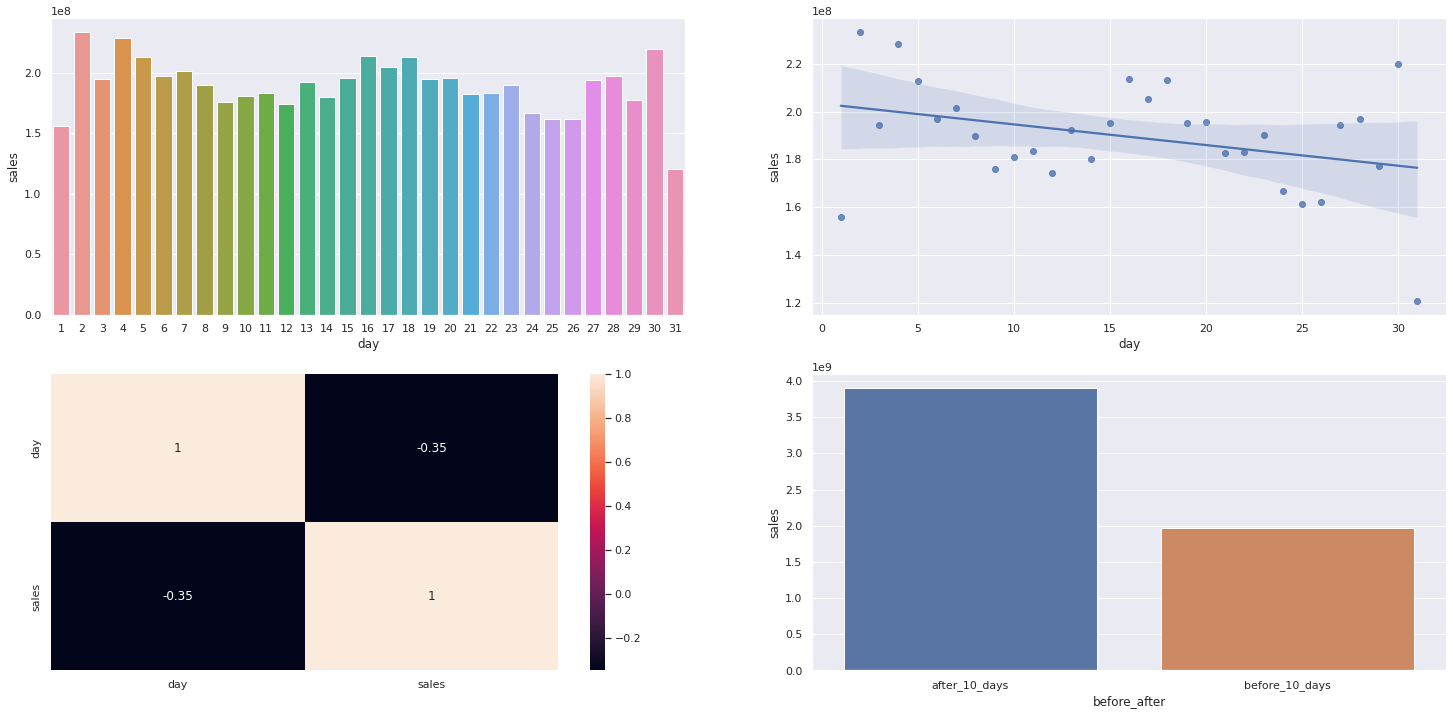

In [51]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

## **H11.** Lojas deveriam vender menos aos finais de semana.
***Verdadeira*** Lojas vendem menos no final de semana


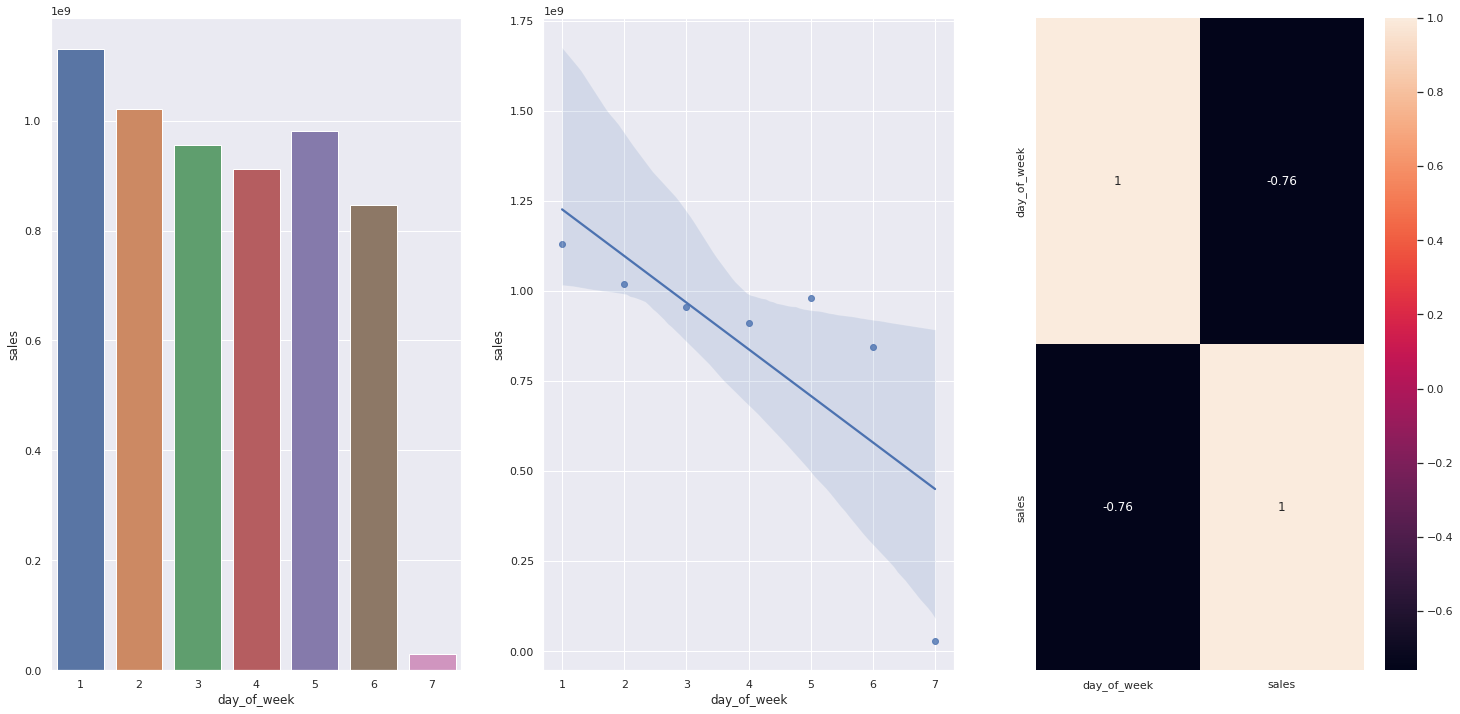

In [52]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H12.** Lojas deveriam vender menos durante os feriados escolares
***Verddeiro*** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e agosto

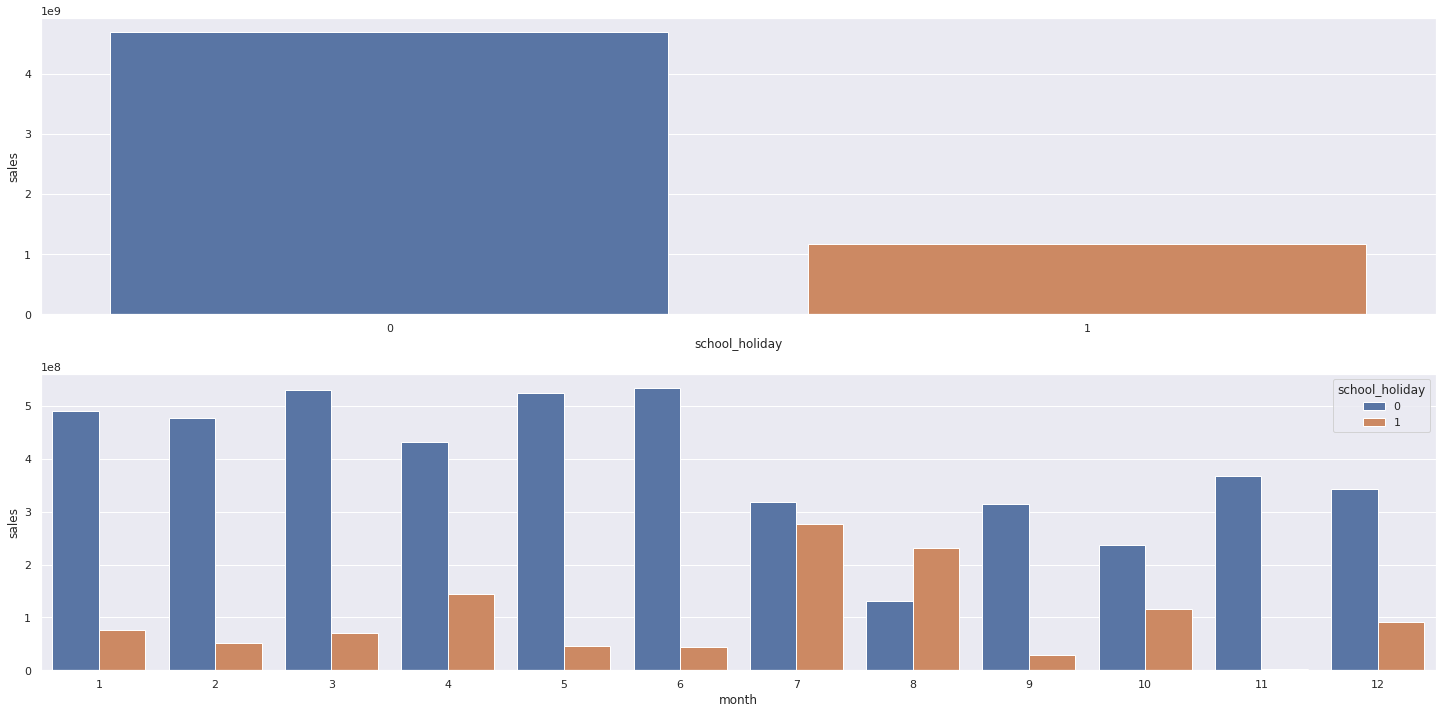

In [53]:
aux1 =df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);


aux2 =df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipoteses

In [54]:
tab =[ ['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Media'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
     ]
print( tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Media
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

In [55]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


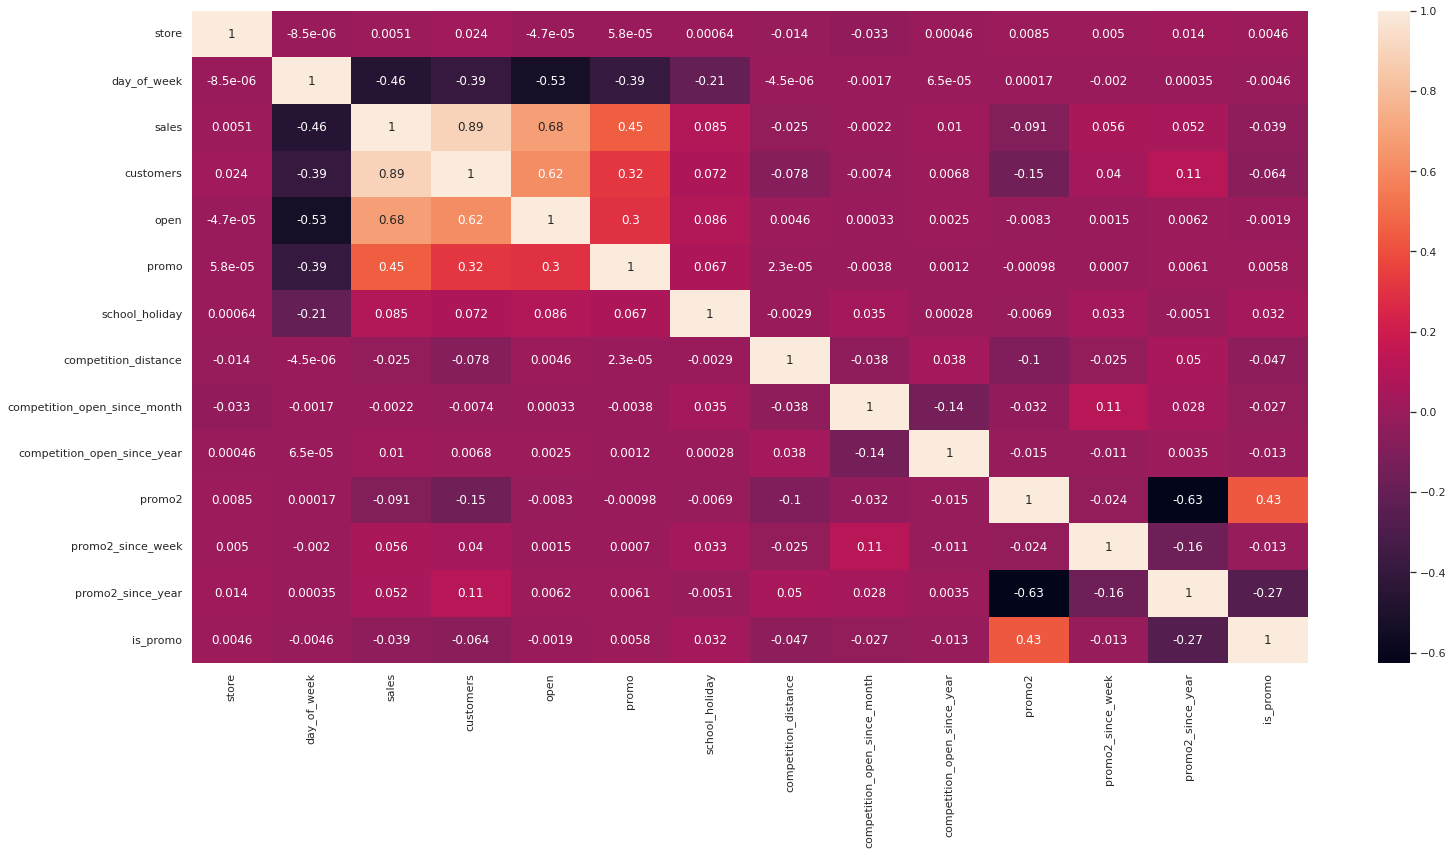

In [56]:
correlation =num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

In [57]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [58]:
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [59]:
#pd.crosstab( a['state_holiday'], a['store_type']).as_matrix()

In [60]:
# only categorical data
a = df4.select_dtypes( include='object')
#cramer_v( a['state_holiday'], a['state_holiday'] )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

<AxesSubplot:>

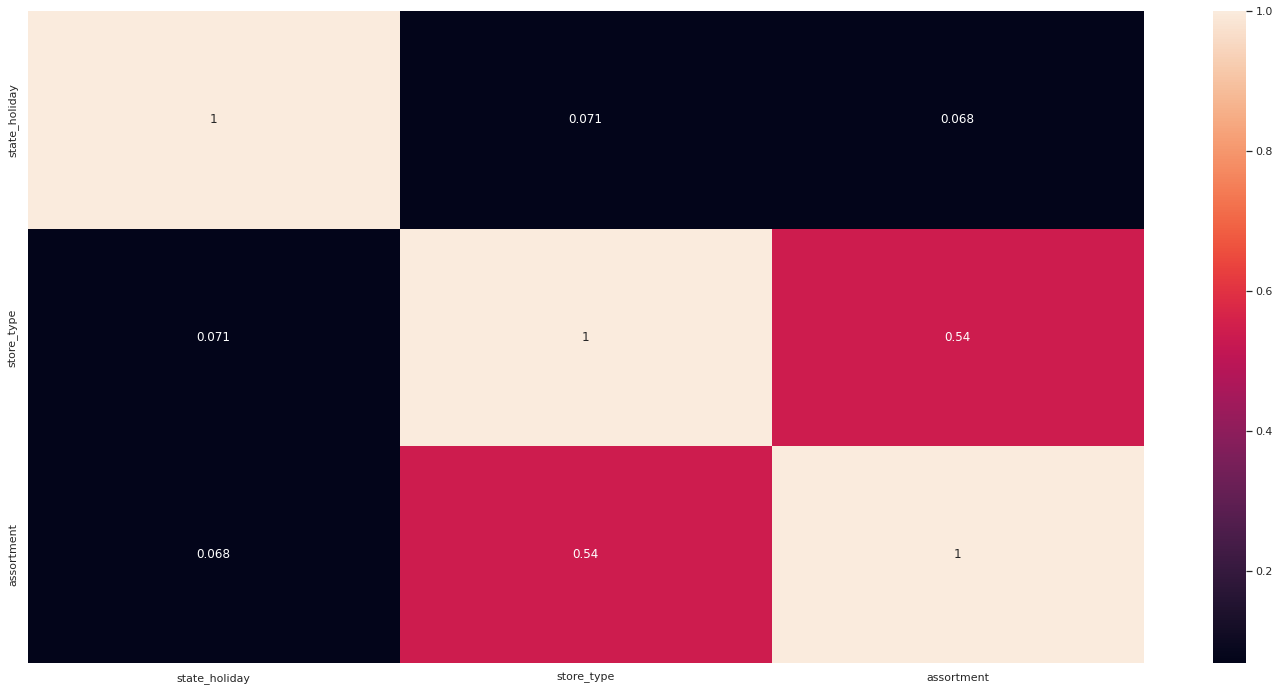

In [61]:
sns.heatmap(d, annot=True )

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS -  DATA PREPARATION

In [62]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [63]:
a =df5.select_dtypes( include=['int64', 'int32', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


<AxesSubplot:xlabel='promo_time_week'>

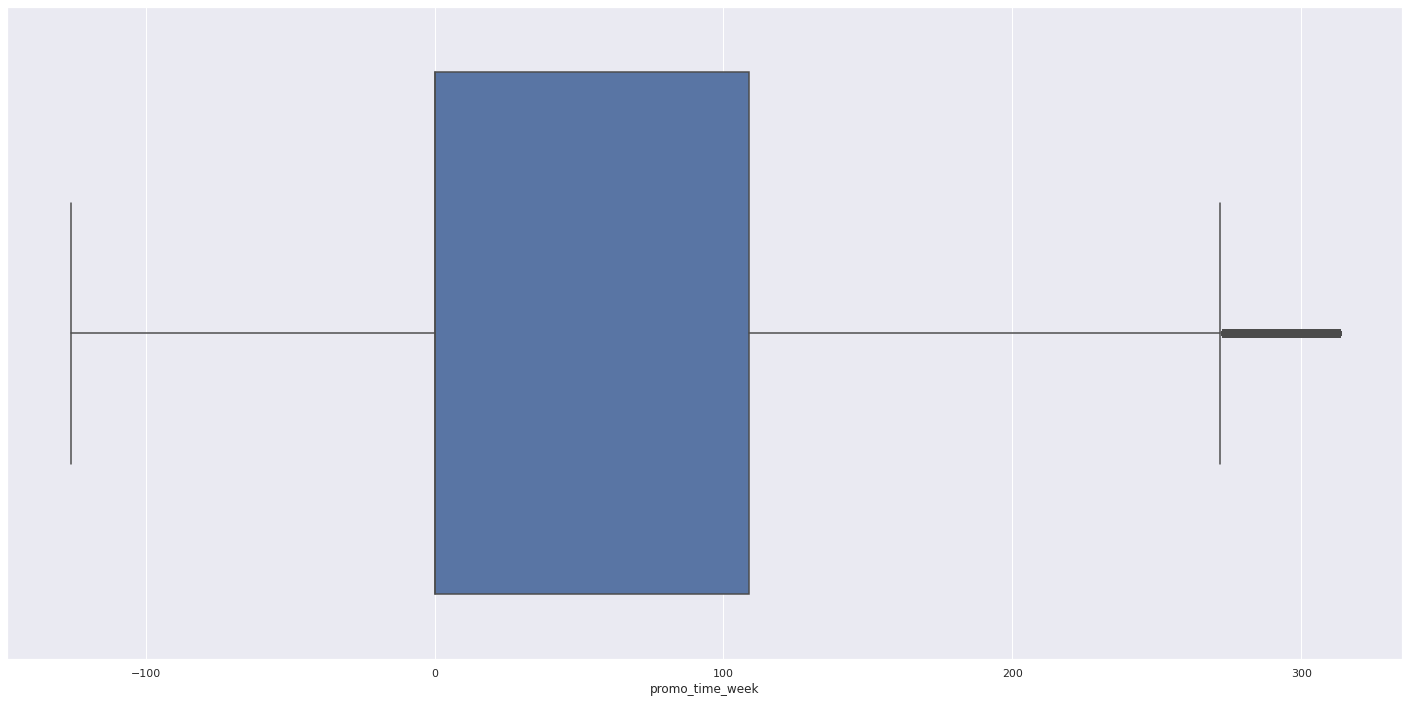

In [64]:
# verificando colunas com outliers
#sns.boxplot( df5['competition_distance'])
#sns.boxplot( df5['competition_time_month'])
sns.boxplot( df5['promo_time_week'])
#sns.boxplot( df5['year'])

In [65]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
#salvando
pickle.dump( rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
#salvando
pickle.dump( rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))


# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
#salvando
pickle.dump( rs, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
#salvando
pickle.dump( mms, open('../parameter/year_scaler.pkl', 'wb'))

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

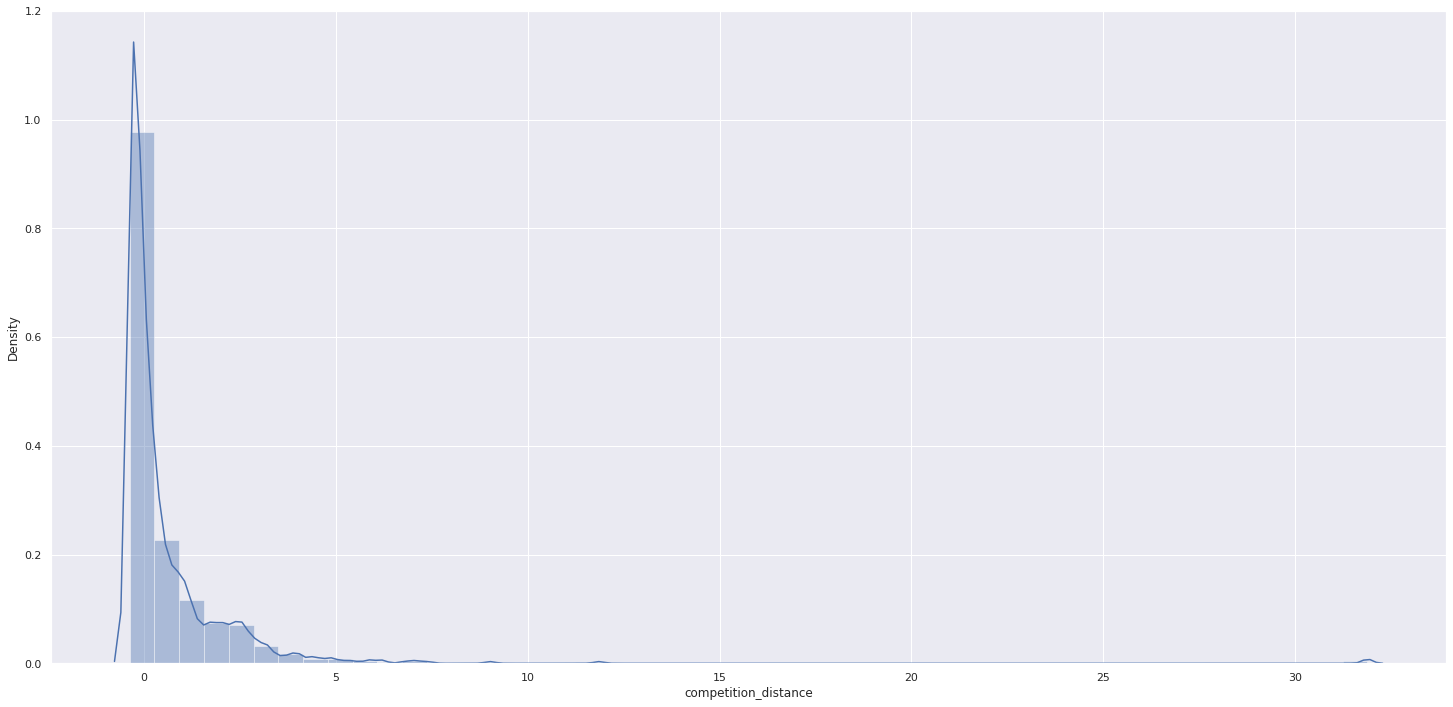

In [66]:
# verificando colunas depois de fazer o rescaling
sns.distplot( df5['competition_distance'])
#sns.distplot( df5['competition_time_month'])
#sns.distplot( df5['promo_time_week'])
#sns.distplot( df5['year'])

## 5.3. Transformação

### 5.3.1. Encoding

In [67]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [68]:
#state_holiday - One Hot Encoding  - cria uma coluna para cada tipo de feriado colocando 0 ou 1
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [69]:
# store_type - Label Encoding - coloca um numero sequencial para cada valor dentro da coluna
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#salvando
pickle.dump( le, open('../parameter/store_type_scaler.pkl', 'wb'))

df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [70]:
#assortment - Ordinal Encoding - eu defino o numero para cada valor dentro da coluna
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable Transformation

<AxesSubplot:xlabel='sales', ylabel='Density'>

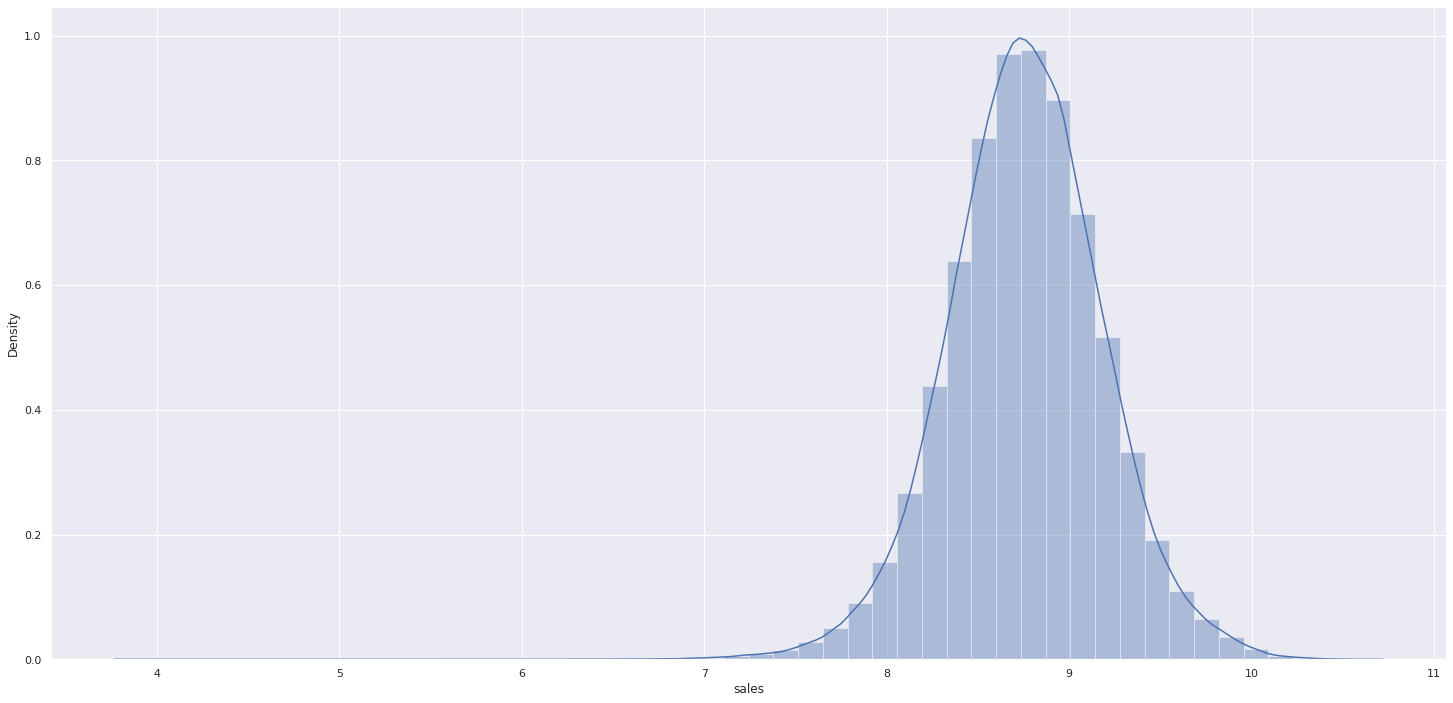

In [71]:
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot( df5['sales'])

### 5.3.3. Nature Transformation

In [72]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * ( 2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * ( 2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * ( 2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * ( 2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * ( 2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * ( 2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52) ) )

df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [73]:
df6 = df5.copy()

## 6.1. SPLIT DATAFRAME INTO TRAINING AND TEST DATASET

In [74]:
# REMOVER AS COLUNAS COM DADOS DUPLICADOS OU DADOS QUE GERARAM OUTRAS COLUNAS
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [131]:
# Descobrindo a menor data de vendas
#print( df6[['store', 'date']].groupby('store').min().reset_index()['date'] )

In [132]:
# Descobrindo a maior data de vendas
#print( df6[['store', 'date']].groupby('store').max().reset_index()['date'] )

In [77]:
# Descobrindo a maior data de vendas - Removendo 6 semanas
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [78]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. BORUTA AS FEATURE SELECTOR

In [79]:
# training and test dataset for Boruta
# deletando as colunas date, sales e copiando só os valores, sem copiar o dataframe
#X_train_n = X_train.drop( ['date', 'sales'], axis=1).values

# copiando só os valores, sem copiar o dataframe,  ravel --> coloca dentro de um vetor
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
# ( n_jobs=-1 )  -->  usar todos os cores da maquina e fazer o processamento em paralelo
#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
# comentei paa não rodar o boruta e preciso gravar  o resultado, que são as features mais importantes
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [80]:
#X_train_n

### 6.2.1. Best Features from Boruta

In [81]:
# support_ --> ranking de classificação das variaveis (colunas)
#cols_selected = boruta.support_.tolist()

# x_train é um vetor e preciso colocar este resultado em um DF
# Crio uma variavel x_train_fs --> coloco os dados do DF xtrain e dropo as colunas q tirei 
# coloco o resultado do boruta neste DF
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
# comparo as colunas selecionadas , menos todas as colunas,para identificar as colunas não selecionadas --> setdiff1d
#cols_not_selected_boruta = list( np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [82]:
#cols_selected_boruta
#cols_not_selected_boruta

## 6.3. Manual Features Selection

In [83]:
# depois de rodar o boruta para classificação das features, fiz a copia das features para uso manual posterior, não sendo necessário rodar o boruta novamente
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [84]:
#cols_not_selected_boruta = ['school_holiday', 'year']
#cols_selected_boruta

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [85]:
df7 = df6.copy()

In [86]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.502080


## 7.1. Average Model

In [87]:
#def mean_absolute_percentage_error( y, yhat ):
#    return np.mean( np.abs( ( y -yhat ) / y ) )

#def ml_error( model_name, y, yhat ):
#    mae = mean_absolute_error(y, yhat )
#    mape = mean_absolute_percentage_error(y, yhat )
#    rmse = np.sqrt(mean_squared_error( y, yhat) )
    
#    return pd.DataFrame( {'Model Name': model_name,
#                          'MAE': mae,
#                          'MAPE': mape,
#                          'RMSE': rmse }, index=[0] )

In [88]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [89]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [90]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=True )


KFold Number: 5 

KFold Number: 4 

KFold Number: 3 

KFold Number: 2 

KFold Number: 1 


In [91]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [92]:
# Model
lrr = Lasso(alpha=0.000001).fit( x_train, y_train )

# Prediction
yhat_lrr = lrr.predict( x_test )

# Performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1867.266034,0.292721,2671.419124


### 7.3.1. Lasso - Linear Regression Regularized Model - Cross Validation

In [93]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=True )


KFold Number: 5 

KFold Number: 4 

KFold Number: 3 

KFold Number: 2 

KFold Number: 1 


In [94]:
lrr_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2081.76 +/- 295.68,0.3 +/- 0.02,2952.6 +/- 468.35


## 7.4. Random Forest Regressor

In [95]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict( x_test )

# Performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


### 7.4.1 Random Forest Regressor - Cross Validation

In [96]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )


KFold Number: 5 

KFold Number: 4 

KFold Number: 3 

KFold Number: 2 

KFold Number: 1 


In [97]:
rf_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5. XGBoost Regressor

In [98]:
# Model
model_xgb = xgb.XGBRegressor(objective= 'reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit( x_train, y_train )
                            # colsample_bytee

# Prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6739,0.949475,7330.979785


### 7.5.1. XGBoost Regressor - Cross Validation

In [99]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )


KFold Number: 5 

KFold Number: 4 

KFold Number: 3 

KFold Number: 2 

KFold Number: 1 


In [100]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.16 +/- 588.44,0.95 +/- 0.0,7715.2 +/- 689.21


## 7.6. Compare Model´s Performance

### 7.6.1 Single Performance

In [101]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1867.266034,0.292721,2671.419124
0,XGBoost Regressor,6683.673900,0.949475,7330.979785


### 7.6.2 Real Performance - Cross Validation

In [102]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv.sort_values('RMSE')
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2081.76 +/- 295.68,0.3 +/- 0.02,2952.6 +/- 468.35
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,7049.16 +/- 588.44,0.95 +/- 0.0,7715.2 +/- 689.21


### Testando Cross Validation

In [103]:
model = LinearRegression()
a = cross_validation( x_training, 5, 'Linear Regression', model, verbose=True )


KFold Number: 5 

KFold Number: 4 

KFold Number: 3 

KFold Number: 2 

KFold Number: 1 


In [104]:
a

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


In [105]:
model = Lasso()
b = cross_validation( x_training, 5, 'Lasso', model,  verbose=True  )


KFold Number: 5 

KFold Number: 4 

KFold Number: 3 

KFold Number: 2 

KFold Number: 1 


In [106]:
b

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [107]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     #'n_estimators': [15, 17, 25, 30, 35],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 10
#MAX_EVAL = 2

In [108]:

# Comentar para não executar mais

#final_result = pd.DataFrame()

#for i in range ( MAX_EVAL):
    # choose values for parameters dandomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
    
    #model
#    model_xgb = xgb.XGBRegressor(objective= 'reg:squarederror',
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'] )
    # Performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat( [final_result, result] )
 
#final_result

In [109]:
#{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
#{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
#{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
#{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
#{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
#{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}
#{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 15}
#{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
#{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, ''is_promo',colsample_bytree': 0.7, 'min_child_weight': 15}
#{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}

## 8.2 Final Model

In [110]:
# depois de XBost para identificar os melhores parametros para o modelo, fiz a cópia dos dados para rodar manualmente em uso posterioir
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }
#MAX_EVAL = 2

In [111]:
# Model
model_xgb_tuned = xgb.XGBRegressor(objective= 'reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )
                            # colsample_bytee

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# Performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6739,0.949475,7330.979785


In [112]:
np.expm1( y_test ).min()

569.0000000000002

In [113]:
np.expm1( y_test ).max()

41550.99999999998

In [114]:
np.expm1( y_test ).max() - np.expm1( y_test ).min()

40981.99999999998

In [115]:
np.expm1( y_test ).mean()

6995.162576094309

In [116]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ))
mpe

-0.016993293553199094

In [117]:
# Salvando o resultado (modelo treinado)
pickle.dump(model_xgb_tuned, open('/home/leandro/repos/rossmann_store_sales_prediction/model/model_rossmann.pkl', 'wb'))

# 9.0 PASSO 09 - Tradução e Interpretação do ERRO

In [118]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [119]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAE'})                                                       
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'}) 

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [120]:
df9_aux1.head()

,store,MAE
0,1,300.793596
1,2,443.228476
2,3,651.429384
3,4,879.374393
4,5,407.541451


In [121]:
df9_aux2.head()

,store,MAPE
0,1,0.068839
1,2,0.089009
2,3,0.088801
3,4,0.083580
4,5,0.092043


In [122]:
df9_aux3.head()

,store,MAE,MAPE
0,1,300.793596,0.068839
1,2,443.228476,0.089009
2,3,651.429384,0.088801
3,4,879.374393,0.083580
4,5,407.541451,0.092043


In [123]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,166816.421875,166515.628279,167117.215471,300.793596,0.068839
1,2,182425.453125,181982.224649,182868.681601,443.228476,0.089009
2,3,265554.687500,264903.258116,266206.116884,651.429384,0.088801
3,4,343276.125000,342396.750607,344155.499393,879.374393,0.083580
4,5,172728.250000,172320.708549,173135.791451,407.541451,0.092043


In [124]:
df92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106171.351562,102781.272397,109561.430728,3390.079166,0.587557
908,909,222328.015625,214455.375870,230200.655380,7872.639755,0.518544
901,902,198744.593750,197370.631757,200118.555743,1373.961993,0.341750
169,170,202679.281250,201303.897177,204054.665323,1375.384073,0.338774
875,876,197616.000000,193510.122442,201721.877558,4105.877558,0.335593


<AxesSubplot:xlabel='store', ylabel='MAPE'>

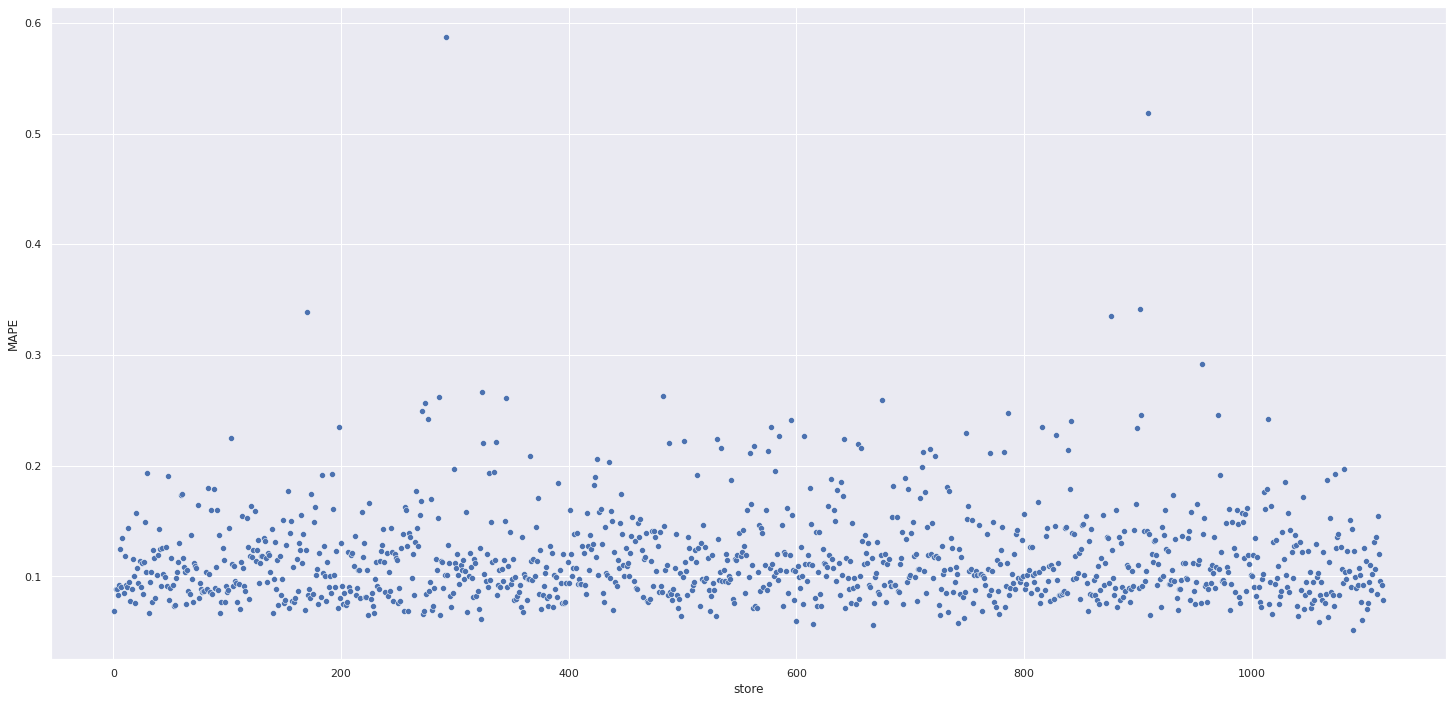

In [125]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2 Total Performance

In [126]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'})           
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$286,304,320.00"
1,worst_scenario,"R$285,443,146.28"
2,best_scenario,"R$287,165,461.67"


## 9.3 Machine Learning Performance

In [127]:
df9['error'] = df9['sales'] -df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

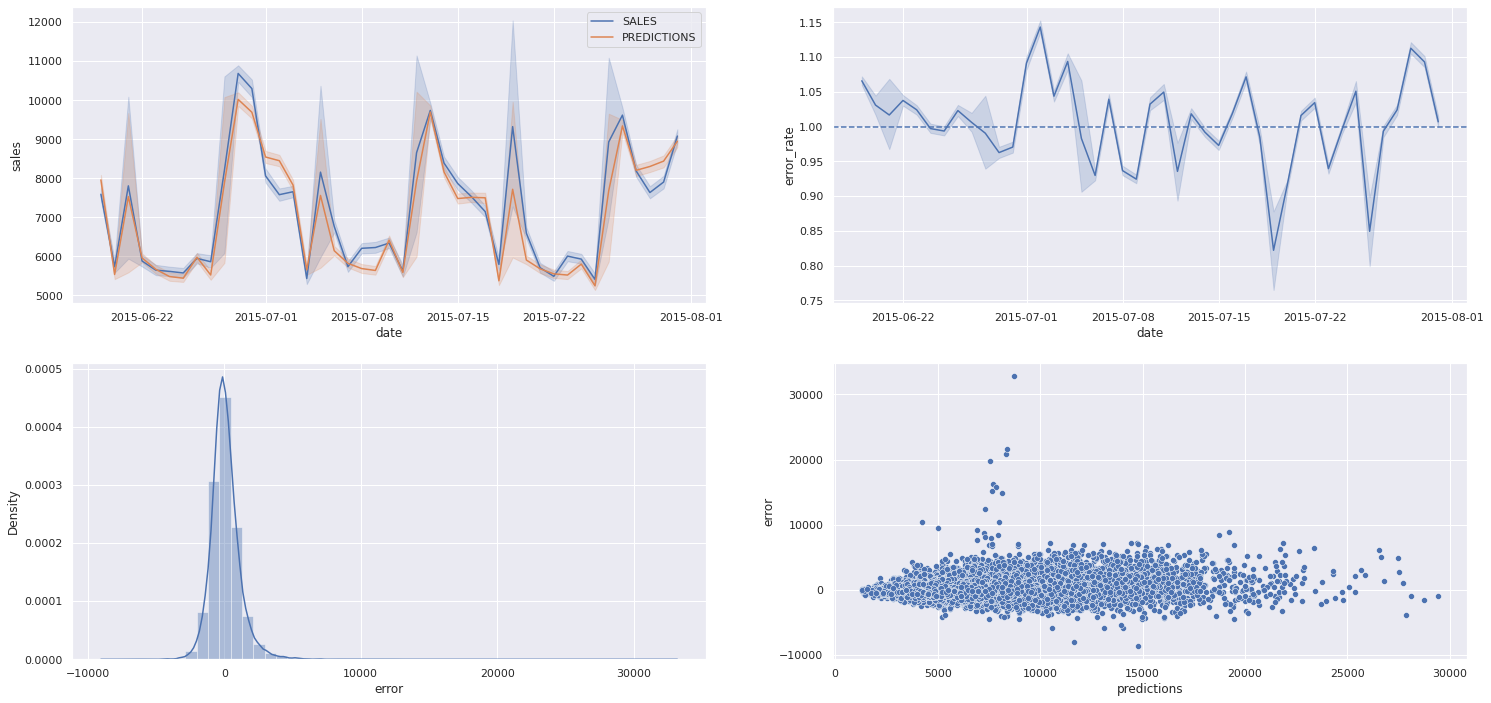

In [128]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot(2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot( df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'])

# 10.0 PASSO 10 - DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [130]:
# Classe de limpeza , Transformação e Encoding  (Rossmann.py)
import pickle
import inflection
import pandas as pd 
import numpy as np
import math 
import datetime


class Rossmann( object ):
    def __init__(self):
        self.home_path='/home/leandro/repos/rossmann_store_sales_prediction/'
        self.competition_distance_scaler   = pickle.load( open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load( open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load( open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load( open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        
    def data_cleaning( self, df1):    

        # 1.0. PASSO 01 - DESCRICAO DOS DADOS
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x)
        cols_new = list( map(snakecase, cols_old)) 

        #rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA
        #competition_distance              
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #===============================================================================================================
        #competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #===============================================================================================================
        #competition_open_since_year     
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


        #===============================================================================================================
        #promo2_since_week 
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)


        #===============================================================================================================
        #promo2_since_year               
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)


        #===============================================================================================================
        #promo_interval 
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
'is_promo',
        # Colocando 0 nos registros que possui a coluna promo_interval = 0
        df1['promo_interval'].fillna(0, inplace=True)

        # Criei uma coluna month_map onde será gravado o mes da coluna 'date' do registro, já convertido de acordo com a biblioteca criada
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        # Criei uma nova coluna que vai registrar 1 para quem tem promoção no mes de venda e 0 data de venda fora da promoçao
        #df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['promo_interval'].split( ',') else 0, axis=1)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis=1)
        #===============================================================================================================

        ## 1.6. Change types
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    # -------------------------------------------------

    def feature_engineering(self, df2 ):
            
        # 2.0. PASSO 02 - FEATURE ENGINEERING
        # Year
        df2['year'] = df2['date'].dt.year

        # Month
        df2['month'] = df2['date'].dt.month

        # Day
        df2['day'] = df2['date'].dt.day

        # Week of Year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        #df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # Year Week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30 ).apply(lambda x: x.days).astype(int)

        # Promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7 ).apply(lambda x: x.days).astype(int)

        # ASSORTMENT
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # State holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 


        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2
    
# --------------------------------------------------------

    def data_preparation( self, df5):
        
        # 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS -  DATA PREPARATION
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)

        # year
        df5['year'] =self.year_scaler.fit_transform( df5[['year']].values)


        ## 5.3. Transformação
        ### 5.3.1. Encoding
        #state_holiday - One Hot Encoding  - cria uma coluna para cada tipo de feriado colocando 0 ou 1
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding - coloca um numero sequencial para cada valor dentro da coluna
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        #assortment - Ordinal Encoding - eu defino o numero para cada valor dentro da coluna
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * ( 2. * np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * ( 2. * np.pi/7) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * ( 2. * np.pi/12) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * ( 2. * np.pi/12) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * ( 2. * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * ( 2. * np.pi/30) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                                'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                                'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',  'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5 [cols_selected]

    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json( orient='records', date_format='iso')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 88)

## 10.2 API Handler

In [ ]:
# Criando API (Handler.py)

import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
#model = pickle.load( open('/Users/leandro.figueira/Repos/DS_em_producao/model/model_rossmann.pkl', 'rb') )
model = pickle.load( open("/home/leandro/repos/rossmann_store_sales_prediction/model/model_rossmann.pkl", 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:   # there is data
        if isinstance( test_json, dict ):   # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else:   # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
            
        # Instantiate Rossman class-----------------------
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1)
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    #--------------------------------------------------------
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0' )       

## 10.3. API Tester

In [ ]:
import requests

In [ ]:
#loading test dataset
df10 = pd.read_csv('/home/leandro/repos/rossmann_store_sales_prediction/data/test.csv')

In [ ]:
# merge tst dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'] == 41]      # pegando linhas, onde a coluna STORE é 22
#df_test = df_test[df_test['Store'].isin([24, 12, 22] ) ]  # pegando linhas, onde a coluna STORE é 24, 12, 22

#remove closed days                             --  removendo dias de lojas fechadas ou valor vazio
df_test = df_test[df_test['Open'] != 0 ]        # pegando linhas, onde a coluna OPEN é diferente 0
df_test = df_test[~df_test['Open'].isnull()]    # pegando linhas, onde a coluna OPEN não é vazio 
df_test = df_test.drop( 'Id', axis=1)           # deletando a coluna ID

In [ ]:
# convert Dataframe to Json
data = json.dumps(df_test.to_dict( orient='records'))

In [ ]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content_type': 'application/json'}
data = data   # Carregando o arquivo json

r = requests.post( url, data=data, headers=header)
print( 'Status Code {}'.format( r.status_code))

In [ ]:
# API Call HEROKU
#https://rossmann-model-tes.herokuapp.com/ | https://git.heroku.com/rossmann-model-tes.git

url = 'https://rossmann-prediction-lfa.herokuapp.com/rossmann/predict'
header = {'Content_type': 'application/json'}
data = data   # Carregando o arquivo json

r = requests.post( url, data=data, headers=header)
print( 'Status Code {}'.format( r.status_code))

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [ ]:
# Mostrar somatoria
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len(d2) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

In [ ]:
d2